# 🧮 Quantitative Portfolio Analysis and Optimization

This notebook systematically analyzes asset returns using **Fama-French 3-Factor (FF3)** and **Fama-French 5-Factor (FF5)** models, compares their performance, and performs portfolio optimization based on factor exposures and risk aversion.

## 📦 Notebook Structure

### 1️⃣ Import Essential Libraries
Load all necessary packages for **data analysis, visualization, and modeling**.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import yfinance as yf
import cvxpy as cp
import seaborn as sns
import statsmodels.api as sm


### 2️⃣ 🛠️ Functions
Reusable modular functions for:
- Data fetching and cleaning
- Regression (FF3 and FF5)
- Portfolio optimization
- Backtesting and evaluation
- Visualization utilities

In [6]:
def fetch_data(tickers, start=None, end=None):
    """
    Fetches monthly adjusted close prices and computes monthly returns for given tickers.

    Parameters:
    - tickers (list): List of ticker symbols (e.g., ['AAPL', 'MSFT']).
    - start (str): Start date in 'YYYY-MM-DD' format (required).
    - end (str): End date in 'YYYY-MM-DD' format (optional).

    Returns:
    - adj_close (pd.DataFrame): DataFrame of monthly adjusted close prices.
    - returns (pd.DataFrame): DataFrame of monthly percentage returns.
    """

    # Validate start date
    if not start:
        raise ValueError("❌ Start date is required in 'YYYY-MM-DD' format.")
    try:
        datetime.strptime(start, "%Y-%m-%d")
    except ValueError:
        raise ValueError("❌ Start date must be in 'YYYY-MM-DD' format (e.g., 2020-01-01).")

    # Validate end date if provided
    if end:
        try:
            datetime.strptime(end, "%Y-%m-%d")
        except ValueError:
            raise ValueError("❌ End date must be in 'YYYY-MM-DD' format (e.g., 2020-12-31).")

    # Download monthly data using yfinance
    data = yf.download(
        tickers,
        start=start,
        end=end,
        group_by='ticker',
        interval='1mo',
        auto_adjust=True
    )

    # Handle data structure: single ticker vs multiple tickers
    if isinstance(data.columns, pd.MultiIndex):
        # MultiIndex columns: extract 'Close' prices for all tickers
        try:
            adj_close = data.xs('Close', level=1, axis=1)
        except KeyError:
            raise ValueError("❌ 'Close' prices not found — possibly all tickers failed.")
    else:
        # Single ticker: ensure 'Close' is present
        if 'Close' in data.columns:
            adj_close = data['Close'].to_frame()
        else:
            raise ValueError("❌ No 'Close' column found in data.")

    # Drop columns with all NaN values (fully failed tickers)
    adj_close = adj_close.dropna(axis=1, how='all')

    # Identify successfully fetched tickers vs failed tickers
    successful = list(adj_close.columns)
    failed = [t for t in tickers if t not in successful]

    if not successful:
        raise ValueError("❌ All tickers failed to download.")

    if failed:
        print(f"⚠️ The following tickers failed to download (check spelling or delisting): {failed}")

    # Calculate monthly percentage returns
    returns = adj_close.pct_change().dropna()

    return adj_close, returns

In [7]:
def ff_regression_analysis(merged_data, model_type):
    """
    Run Fama-French FF3 or FF5 regression analysis on merged_data.
    
    Parameters:
    - merged_data: DataFrame with 'Excess Return' and factor columns.
    - model_type: 'FF3' or 'FF5'
    
    Returns:
    - model: last fitted statsmodels OLS model
    - coef_df.T: Transposed DataFrame of coefficients and errors
    """

    if model_type == 'FF5':
        factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
    else:
        factors = ['Mkt-RF', 'SMB', 'HML']

    alpha_list = []
    stderr_alpha = []
    adj_r_squared_list = []
    factor_lists = {factor: [] for factor in factors}
    stderr_lists = {factor: [] for factor in factors}

    tickers = merged_data['Ticker'].unique()

    for ticker in tickers:
        group = merged_data[merged_data['Ticker'] == ticker]
        X = group[factors]
        X = sm.add_constant(X)
        y = group['Excess Return']

        model = sm.OLS(y, X).fit()
        print(f"\n📊 {model_type} Regression Summary for {ticker}")
        print(model.summary(), end="\n\n")

        alpha_list.append(model.params['const'])
        stderr_alpha.append(model.bse['const'])
        adj_r_squared_list.append(model.rsquared_adj)

        for factor in factors:
            factor_lists[factor].append(model.params[factor])
            stderr_lists[factor].append(model.bse[factor])

    data = {
        'Ticker': tickers,
        'Alpha': alpha_list,
        'Alpha_err': stderr_alpha,
        'Adj_R2': adj_r_squared_list
    }
    for factor in factors:
        data[factor] = factor_lists[factor]
        data[factor + '_err'] = stderr_lists[factor]

    coef_df = pd.DataFrame(data).set_index('Ticker')

    coef_columns = ['Alpha'] + factors
    err_columns = ['Alpha_err'] + [f + '_err' for f in factors]

    coef_df[coef_columns].plot(
        kind='bar',
        yerr=coef_df[err_columns].values.T,
        capsize=4,
        figsize=(12, 6)
    )
    plt.title(f'Fama-French {model_type}-Factor Coefficients with Error Bars')
    plt.ylabel('Coefficient Value')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return model, coef_df.T

In [8]:
def display_regression_parameters(coef_df, model_type):
    """
    Displays regression parameters (coefficients and adjusted R²) for FF3 or FF5 models
    using a styled, clear, and consistent table.

    Parameters:
    - coef_df (pd.DataFrame): DataFrame containing regression results (tickers as columns or index).
    - model_type: Name of the model ('FF3', 'FF5', etc.) for display labeling.

    Displays:
    - Styled DataFrame with:
        - 4 decimal formatting
        - Blue gradient highlighting
        - Title indicating the model type
    """

    print(f"\n📊 {model_type} Regression Parameters:")
    display(
        coef_df.round(4).style
        .format("{:.4f}")
        .background_gradient(cmap='Blues')
        .set_caption(f"{model_type} Regression Coefficients and Adjusted R²")
    )

In [9]:
def ff_fitted_plt(merged_data, model_type):
    """
    Plot actual vs fitted regression values for each ticker using FF3 or FF5 model.
    
    Parameters:
    - merged_data: DataFrame containing factor data, 'Excess Return', and 'Ticker'.
    - model_type: 'FF3' or 'FF5' to select factor model.
    """
    sns.set_style("whitegrid")

    if model_type == 'FF5':
        factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
    else:
        factors = ['Mkt-RF', 'SMB', 'HML']

    tickers = merged_data['Ticker'].unique()
    for ticker in tickers:
        group = merged_data[merged_data['Ticker'] == ticker].copy()
        if group.shape[0] < 5:
            print(f"⚠️ Skipping {ticker} — not enough data points.")
            continue

        group = group.sort_values(by='Mkt-RF')  # For consistent plotting

        X = group[factors]
        X = sm.add_constant(X)
        y = group['Excess Return']
        model = sm.OLS(y, X).fit()

        plt.figure(figsize=(8, 5))
        plt.scatter(group['Mkt-RF'], y, label='Actual', alpha=0.7)
        plt.plot(group['Mkt-RF'], model.fittedvalues, color='red', label='Fitted', linewidth=2)
        plt.xlabel('Mkt-RF')
        plt.ylabel('Excess Return')
        plt.title(f'{model_type} Regression: {ticker} (R² = {model.rsquared:.2f})')
        plt.legend()
        plt.tight_layout()
        plt.show()

In [10]:
def optimize_portfolio(expected_excess_return, cov_matrix, tickers, risk_aversion, allow_short=False):
    """
    Optimizes portfolio weights using mean-variance optimization for FF3 or FF5.

    Parameters:
    - expected_excess_return: np.array of expected excess returns (from FF3 or FF5)
    - cov_matrix: np.array covariance matrix of returns
    - tickers: list of tickers
    - risk_aversion: float, higher = more conservative
    - allow_short: bool, if True, allows short selling (weights can be negative)

    Returns:
    - pd.DataFrame with ['Ticker', 'Weight']
    """
    n = len(tickers)
    w = cp.Variable(n)

    # Objective: maximize expected return minus risk penalty
    objective = cp.Maximize(expected_excess_return @ w - risk_aversion * cp.quad_form(w, cov_matrix))

    # Constraints
    constraints = [cp.sum(w) == 1]
    if not allow_short:
        constraints.append(w >= 0)

    prob = cp.Problem(objective, constraints)
    prob.solve()

    if prob.status != 'optimal':
        raise ValueError(f"Optimization did not converge: {prob.status}")

    # Clean small weights and package
    weights = np.where(np.abs(w.value) < 1e-5, 0, w.value.round(6))
    return pd.DataFrame({'Ticker': tickers, 'Weight': weights})

In [11]:
def plot_portfolio_pie(weights_df, model_type):
    """
    Plots a donut-style pie chart to visualize the weight allocation of an optimized portfolio.

    Parameters:
    - weights_df (pd.DataFrame): DataFrame containing 'Ticker' and 'Weight' columns with portfolio weights.
    - model_type (str): Model identifier for the title (e.g., 'FF3', 'FF5').

    Function Details:
    - Filters out tickers with zero weight for clarity.
    - Displays each ticker with its percentage allocation.
    - Uses a donut style for a cleaner, modern presentation.
    - Includes a legend and clear labeling for interpretation.
    """
    # Filter out zero-weight tickers
    filtered_df = weights_df[weights_df['Weight'] > 0].copy()
    labels = filtered_df['Ticker'] + ' (' + (filtered_df['Weight'] * 100).round(1).astype(str) + '%)'
    sizes = filtered_df['Weight'] * 100

    # Dynamic color gradient based on number of assets
    cmap = plt.cm.Blues
    colors = cmap(np.linspace(0.4, 0.8, len(filtered_df)))

    # Initialize plot
    fig, ax = plt.subplots(figsize=(7, 6))
    wedges, texts, autotexts = ax.pie(
        sizes,
        labels=labels,
        autopct='%1.1f%%',
        startangle=90,
        textprops={'fontsize': 13, 'weight': 'bold'},
        wedgeprops=dict(width=0.4, edgecolor='white'),
        colors=colors
    )

    # Add center circle for donut style
    centre_circle = plt.Circle((0, 0), 0.70, fc='white')
    ax.add_artist(centre_circle)

    # Add title with model type
    ax.set_title(f"Optimized Portfolio Allocation ({model_type})",
                 fontsize=16, fontweight='bold', pad=20)

    # Add legend below the plot
    ax.legend(
        wedges,
        filtered_df['Ticker'],
        title="Tickers",
        loc='lower center',
        bbox_to_anchor=(0.5, -0.15),
        ncol=min(len(labels), 4),
        fontsize=11,
        title_fontsize=12,
        frameon=False
    )

    # Ensure circular aspect ratio
    ax.axis('equal')
    plt.tight_layout()
    plt.show()

In [12]:
def compute_portfolio_returns(weights_df, returns_df):
    """
    Computes the portfolio returns based on provided weights and returns dataframe.
    
    Parameters:
    - weights_df: pd.DataFrame with ['Ticker', 'Weight']
    - returns_df: pd.DataFrame with tickers as columns, datetime index, percentage returns

    Returns:
    - portfolio_returns: pd.Series of portfolio returns
    """
    tickers = weights_df['Ticker']
    weights = weights_df['Weight'].values

    # Ensure the returns_df contains required tickers
    missing_tickers = [t for t in tickers if t not in returns_df.columns]
    if missing_tickers:
        raise ValueError(f"❌ Missing tickers in returns_df: {missing_tickers}")

    returns_subset = returns_df[tickers].dropna()
    portfolio_returns = returns_subset @ weights

    return portfolio_returns

In [13]:
def compute_cumulative_returns(returns_series):
    """
    Computes cumulative returns from a return series.
    """
    if returns_series is None:
        return None
    return (1 + returns_series).cumprod()

In [14]:
def compare_portfolios_with_benchmark(
    portfolio_returns_ff3=None,
    portfolio_returns_ff5=None,
    benchmark_returns=None,
    label_ff3='FF3',
    label_ff5='FF5',
    benchmark_label='S&P 500'
):
    """
    Plots:
    - FF3, FF5, Benchmark (if all present)
    - FF3 vs FF5 (if no benchmark)
    - Single model vs Benchmark (if only one model + benchmark)
    """
    has_ff3 = portfolio_returns_ff3 is not None
    has_ff5 = portfolio_returns_ff5 is not None
    has_benchmark = benchmark_returns is not None

    if not has_ff3 and not has_ff5:
        print("⚠️ No portfolio returns provided. Skipping plot.")
        return

    plt.figure(figsize=(14, 6))

    if has_benchmark:
        if has_ff3:
            common_idx = portfolio_returns_ff3.index.intersection(benchmark_returns.index)
            ff3_cum = (1 + portfolio_returns_ff3.loc[common_idx]).cumprod()
            bench_cum = (1 + benchmark_returns.loc[common_idx]).cumprod()
            plt.plot(ff3_cum, label=f'{label_ff3} Optimized Portfolio', color='green')
        
        if has_ff5:
            common_idx = portfolio_returns_ff5.index.intersection(benchmark_returns.index)
            ff5_cum = (1 + portfolio_returns_ff5.loc[common_idx]).cumprod()
            bench_cum = (1 + benchmark_returns.loc[common_idx]).cumprod()
            plt.plot(ff5_cum, label=f'{label_ff5} Optimized Portfolio', color='blue')

        # Plot benchmark only once
        plt.plot(bench_cum, label=benchmark_label, color='black', linestyle='--')

        plt.title(f"📈 Portfolio(s) vs {benchmark_label} Comparison")

    else:
        if has_ff3 and has_ff5:
            # Compare FF3 vs FF5 directly
            common_idx = portfolio_returns_ff3.index.intersection(portfolio_returns_ff5.index)
            ff3_cum = (1 + portfolio_returns_ff3.loc[common_idx]).cumprod()
            ff5_cum = (1 + portfolio_returns_ff5.loc[common_idx]).cumprod()
            plt.plot(ff3_cum, label=f'{label_ff3} Optimized Portfolio', color='green')
            plt.plot(ff5_cum, label=f'{label_ff5} Optimized Portfolio', color='blue')
            plt.title("📈 FF3 vs FF5 Portfolio Performance")
        elif has_ff3:
            ff3_cum = (1 + portfolio_returns_ff3).cumprod()
            plt.plot(ff3_cum, label=f'{label_ff3} Optimized Portfolio', color='green')
            plt.title(f"📈 {label_ff3} Portfolio Performance")
        elif has_ff5:
            ff5_cum = (1 + portfolio_returns_ff5).cumprod()
            plt.plot(ff5_cum, label=f'{label_ff5} Optimized Portfolio', color='blue')
            plt.title(f"📈 {label_ff5} Portfolio Performance")

    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [15]:
def performance_summary(returns, label="Portfolio"):
    """
    Calculates and prints a performance summary for a portfolio based on its return series.

    Metrics calculated:
    - Total Return: Overall growth over the period.
    - Annualized Return: CAGR based on the monthly return series.
    - Annualized Volatility: Standard deviation of returns annualized.
    - Sharpe Ratio: Risk-adjusted return assuming a 0% risk-free rate.
    - Max Drawdown: Largest peak-to-trough decline over the period.

    Parameters:
    - returns (pd.Series): Return series of the portfolio (monthly returns recommended).
    - label (str): Label for the portfolio used in the print summary.

    Returns:
    - summary (dict): Dictionary containing raw numeric values for all metrics.
    """

    # Calculate cumulative returns
    cumulative = (1 + returns).cumprod()

    # Total return over the period
    total_return = cumulative.iloc[-1] - 1

    # Annualized return using CAGR formula
    annualized_return = (1 + total_return) ** (12 / len(returns)) - 1

    # Annualized volatility
    annualized_volatility = returns.std() * (12 ** 0.5)

    # Sharpe Ratio (risk-free rate assumed to be zero)
    sharpe_ratio = annualized_return / annualized_volatility

    # Maximum drawdown
    max_drawdown = ((cumulative / cumulative.cummax()) - 1).min()

    # Prepare display summary with clear formatting
    summary_display = {
        "Total Return": f"{total_return:.2%}",
        "Annualized Return": f"{annualized_return:.2%}",
        "Annualized Volatility": f"{annualized_volatility:.2%}",
        "Sharpe Ratio": f"{sharpe_ratio:.2f}",
        "Max Drawdown": f"{max_drawdown:.2%}"
    }

    print(f"\n📊 Performance Summary: {label}")
    for metric, value in summary_display.items():
        print(f"{metric:<25}: {value}")

    # Return raw numeric values for further processing or table creation
    return {
        "Total Return": total_return,
        "Annualized Return": annualized_return,
        "Annualized Volatility": annualized_volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown": max_drawdown
    }

In [16]:
def plot_relative_performance(portfolio_ret, benchmark_ret, model_type, benchmark_name="S&P 500"):
    """
    Plots the relative cumulative performance of a portfolio against a benchmark.

    Calculation:
    - Computes cumulative returns for both portfolio and benchmark.
    - Plots the difference: Portfolio Cumulative - Benchmark Cumulative.

    Parameters:
    - portfolio_ret (pd.Series): Return series of the portfolio.
    - benchmark_ret (pd.Series): Return series of the benchmark.
    - model_name (str): Label for the portfolio (e.g., 'FF3', 'FF5').
    - benchmark_name (str): Label for the benchmark (e.g., 'S&P 500').

    Displays:
    - A clear plot showing when the portfolio is outperforming (>0) or underperforming (<0) the benchmark.
    """

    # Align dates and drop missing values
    aligned = portfolio_ret.dropna().copy()
    benchmark_aligned = benchmark_ret.reindex(aligned.index).dropna()
    aligned = aligned.loc[benchmark_aligned.index]  # Align both to same dates

    # Compute cumulative returns
    portfolio_cum = (1 + aligned).cumprod()
    benchmark_cum = (1 + benchmark_aligned).cumprod()

    # Compute relative performance
    relative = portfolio_cum - benchmark_cum

    # Plotting
    plt.figure(figsize=(10, 4))
    plt.plot(relative, label=f"{model_type} Portfolio - {benchmark_name}", color='purple')
    plt.axhline(0, linestyle='--', color='grey')
    plt.title(f"Relative Performance ({model_type} - {benchmark_name})")
    plt.xlabel("Date")
    plt.ylabel("Excess Cumulative Return")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [17]:
def compare_ff3_ff5(ff3_df, ff5_df, display_table=True):
    """
    Compare FF3 vs FF5 model outputs:
    - Adjusted R² comparison
    - Alpha comparison
    - Percentage improvement in R²
    - Alpha reduction

    Parameters:
    - ff3_df: pd.DataFrame with FF3 regression results (transposed: tickers as columns)
    - ff5_df: pd.DataFrame with FF5 regression results (transposed: tickers as columns)
    - display_table: bool, whether to display styled summary in notebook

    Returns:
    - comparison_df: DataFrame with comparative metrics
    """
    comparison_df = pd.DataFrame({
        'FF3_Adj_R2': ff3_df.T['Adj_R2'],
        'FF5_Adj_R2': ff5_df.T['Adj_R2'],
        'R2_Improvement': ff5_df.T['Adj_R2'] - ff3_df.T['Adj_R2'],
        'R2_%_Improvement': ((ff5_df.T['Adj_R2'] - ff3_df.T['Adj_R2']) / ff3_df.T['Adj_R2']) * 100,
        'FF3_Alpha': ff3_df.T['Alpha'],
        'FF5_Alpha': ff5_df.T['Alpha'],
        'Alpha_Reduction': ff5_df.T['Alpha'] - ff3_df.T['Alpha']
    })

    print('\n📈 Generating FF3 vs FF5 Comparison Summary...')

    # Bar chart for Adjusted R²
    comparison_df[['FF3_Adj_R2', 'FF5_Adj_R2']].plot(
        kind='bar', figsize=(12, 5),
        title='Adjusted R² Comparison: FF3 vs FF5',
        ylabel='Adjusted R²',
        colormap='viridis'
    )
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    # Bar chart for Alpha
    comparison_df[['FF3_Alpha', 'FF5_Alpha']].plot(
        kind='bar', figsize=(12, 5),
        title='Alpha Comparison: FF3 vs FF5',
        ylabel='Alpha',
        colormap='plasma'
    )
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    if display_table:
        styled_table = (
            comparison_df.round(4)
            .style.format("{:.4f}")
            .background_gradient(cmap='Blues', subset=['FF3_Adj_R2', 'FF5_Adj_R2'])
            .background_gradient(cmap='RdYlGn', subset=['R2_Improvement', 'R2_%_Improvement'])
            .background_gradient(cmap='Greens', subset=['Alpha_Reduction'])
            .set_caption("📊 FF3 vs FF5 Comparison: Adjusted R², Alpha, and Improvements")
        )
        display(styled_table)

    return comparison_df

In [18]:
def analyze_ff3_ff5_comparison(comparison_df):
    """
    Analyze and visualize FF3 vs FF5 comparison results.

    Parameters:
    comparison_df (pd.DataFrame): DataFrame containing FF3 and FF5 Adj_R2, Alpha, improvements.
    """
    # Calculate % improvement in Adjusted R²
    comparison_df['R2_%_Change'] = (comparison_df['R2_Improvement'] / comparison_df['FF3_Adj_R2']) * 100

    # Plot R² % improvement
    ax1 = comparison_df['R2_%_Change'].plot(kind='bar', figsize=(8, 5), color='skyblue', edgecolor='black')
    plt.title('Percentage Improvement in Adjusted R²: FF5 vs FF3')
    plt.ylabel('% Improvement')
    plt.xlabel('Ticker')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Plot Alpha reduction
    ax2 = comparison_df['Alpha_Reduction'].plot(kind='bar', figsize=(8, 5), color='salmon', edgecolor='black')
    plt.title('Alpha Reduction: FF5 vs FF3')
    plt.ylabel('Alpha Difference (FF5 - FF3)')
    plt.xlabel('Ticker')
    plt.axhline(0, linestyle='--', color='gray', linewidth=1)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Text summary per ticker
    print("\n📊 Summary Interpretation:")
    for ticker in comparison_df.index:
        r2_improv = comparison_df.loc[ticker, 'R2_%_Change']
        alpha_red = comparison_df.loc[ticker, 'Alpha_Reduction']
        print(f"{ticker}: Adj R² improved by {r2_improv:.2f}% and Alpha reduced by {alpha_red:.5f}.")

In [19]:
def plot_drawdown_duration_comparison(dd_df):
    """
    Plots side-by-side bar charts of Max and Average Drawdown Duration across portfolios.

    Parameters:
    ----------
    dd_df : pd.DataFrame
        DataFrame with columns ["Model", "Max Drawdown Duration (months)", "Avg Drawdown Duration (months)"].
    """

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    models = dd_df["Model"]
    max_dd = dd_df["Max Drawdown Duration (months)"]
    avg_dd = dd_df["Avg Drawdown Duration (months)"]

    # Dynamically assign colors to match your project or default palette
    colors = ["green", "blue", "black"][:len(models)]

    # Plot Max Duration
    bars0 = ax[0].bar(models, max_dd, color=colors, alpha=0.8)
    ax[0].set_title("Max Drawdown Duration")
    ax[0].set_ylabel("Months")
    ax[0].grid(True, linestyle='--', alpha=0.5)
    ax[0].set_ylim(0, max(max_dd) * 1.2)

    # Annotate values
    for bar in bars0:
        height = bar.get_height()
        ax[0].annotate(f'{height:.0f}',
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center', va='bottom', fontsize=10)

    # Plot Average Duration
    bars1 = ax[1].bar(models, avg_dd, color=colors, alpha=0.8)
    ax[1].set_title("📉 Average Drawdown Duration")
    ax[1].set_ylabel("Months")
    ax[1].grid(True, linestyle='--', alpha=0.5)
    ax[1].set_ylim(0, max(avg_dd) * 1.2)

    # Annotate values
    for bar in bars1:
        height = bar.get_height()
        ax[1].annotate(f'{height:.2f}',
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center', va='bottom', fontsize=10)

    # Rotate x labels for clarity
    for axis in ax:
        axis.tick_params(axis='x', rotation=20)

    plt.suptitle("Drawdown Duration Comparison Across Portfolios", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

In [20]:
def calculate_drawdown_duration(cum_returns, label="Portfolio", period_label="months", verbose=True, return_df=False):
    """
    Calculate maximum and average drawdown duration from cumulative returns.

    Parameters:
    ----------
    cum_returns : pd.Series or pd.DataFrame
        Cumulative returns of the portfolio or benchmark.
    label : str, optional
        Label for the portfolio/benchmark being evaluated.
    period_label : str, optional
        Unit of duration for display ("months", "days", "periods").
    verbose : bool, optional
        If True, prints the duration analysis.
    return_df : bool, optional
        If True, returns a pd.DataFrame with results.

    Returns:
    -------
    tuple or pd.DataFrame:
        If return_df is False:
            (label, max_duration, avg_duration)
        If return_df is True:
            pd.DataFrame with columns ["Model", "Max Drawdown Duration", "Avg Drawdown Duration"]
    """

    if isinstance(cum_returns, pd.DataFrame):
        cum_returns = cum_returns.iloc[:, 0]

    high_water_mark = cum_returns.cummax()
    drawdown = cum_returns / high_water_mark - 1
    in_drawdown = drawdown < 0

    durations = []
    duration = 0
    for d in in_drawdown:
        if d:
            duration += 1
        elif duration != 0:
            durations.append(duration)
            duration = 0
    if duration != 0:
        durations.append(duration)

    max_duration = int(max(durations)) if durations else 0
    avg_duration = round(float(np.mean(durations)), 2) if durations else 0.0

    if verbose:
        print(f"📊 {label} Drawdown Duration Analysis")
        print(f"   • Max Drawdown Duration   : {max_duration} {period_label}")
        print(f"   • Average Drawdown Duration: {avg_duration:.2f} {period_label}\n")

    if return_df:
        result_df = pd.DataFrame({
            "Model": [label],
            "Max Drawdown Duration": [max_duration],
            "Avg Drawdown Duration": [avg_duration]
        })
        return result_df

    return label, max_duration, avg_duration

In [21]:
def plot_drawdown_series(cum_returns, label, color="crimson"):
    """
    Plots the drawdown series from cumulative returns with clean formatting.

    Parameters:
    - cum_returns: pd.Series or pd.DataFrame
        Cumulative returns series to compute drawdown.
    - label: str
        Label for the portfolio/benchmark being plotted.
    - color: str, optional
        Color for the drawdown plot.
    - save_path: str, optional
        If provided, saves the plot to this path.
    - show: bool, optional
        If True, displays the plot.
    """

    # Compute drawdown
    high_water_mark = cum_returns.cummax()
    drawdown = (cum_returns / high_water_mark - 1)*100

    # Ensure drawdown is 1D Series
    if isinstance(drawdown, pd.DataFrame):
        drawdown = drawdown.iloc[:, 0]

    fig, ax = plt.subplots(figsize=(12, 4))

    ax.plot(drawdown.index, drawdown, label=f"{label} Drawdown", color=color, lw=1.5)
    ax.fill_between(drawdown.index, drawdown.values, color=color, alpha=0.3)

    ax.set_title(f"Drawdown Series for {label}", fontsize=14, weight="bold")
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel("Drawdown (%)", fontsize=12)

    ax.grid(True, linestyle="--", alpha=0.4)
    ax.legend()
    ax.set_ylim(drawdown.min() * 1.1, 0.01)  # slight margin for clarity

    plt.tight_layout()
    plt.show()

In [22]:
def calculate_performance_metrics(cum_returns, risk_free_rate):
    """
    Calculates key performance metrics for a cumulative return series:
    CAGR, Volatility, Sharpe Ratio, Sortino Ratio, Max Drawdown, Calmar Ratio.

    Parameters:
    -----------
    cum_returns : pd.Series
        Cumulative return series (e.g., portfolio value normalized to 1).
    risk_free_rate : float
        Annual risk-free rate for Sharpe and Sortino calculations.

    Returns:
    --------
    pd.Series
        Series containing rounded performance metrics.
    """

    periods_per_year = 12

    returns = cum_returns.pct_change().dropna()

    # CAGR
    cagr = ((cum_returns.iloc[-1]) ** (1 / (len(cum_returns) / periods_per_year)) - 1) * 100

    # Volatility
    volatility = returns.std(ddof=1) * (periods_per_year ** 0.5) * 100

    # Sharpe
    excess_returns = returns - risk_free_rate / periods_per_year
    sharpe = excess_returns.mean() / returns.std(ddof=1) * (periods_per_year ** 0.5)

    # Sortino
    downside = returns.copy()
    downside[downside > 0] = 0
    downside_std = downside.std(ddof=1)
    sortino = (
        excess_returns.mean() / downside_std * (periods_per_year ** 0.5)
        if downside_std != 0 else np.nan
    )

    # Max Drawdown
    high_water = cum_returns.cummax()
    drawdown = cum_returns / high_water - 1
    max_drawdown = drawdown.min() * 100

    # Calmar
    calmar = cagr / abs(max_drawdown) if max_drawdown != 0 else np.nan

    return pd.Series({
        "CAGR": round(cagr, 2),
        "Volatility": round(volatility, 2),
        "Sharpe Ratio": round(sharpe, 2),
        "Sortino Ratio": round(sortino, 2),
        "Max Drawdown": round(max_drawdown, 2),
        "Calmar Ratio": round(calmar, 2)
    })

In [23]:
def plot_rolling_sharpe_auto(risk_free_rate):
    """
    Automatically detects cum_ff3 and cum_ff5 in globals() and
    plots their rolling Sharpe Ratios on a single chart if available.

    Parameters:
    -----------
    window : int, default 12
        Rolling window size in months.
    risk_free_rate : float, default 0.03
        Annual risk-free rate for excess return calculation.
    """
    window = 12
    periods_per_year = 12
    returns_dict = {}

    # Auto-detect
    if 'cum_ff3' in globals() and isinstance(globals()['cum_ff3'], pd.Series):
        returns_dict['FF3 Optimized Portfolio'] = globals()['cum_ff3']
    if 'cum_ff5' in globals() and isinstance(globals()['cum_ff5'], pd.Series):
        returns_dict['FF5 Optimized Portfolio'] = globals()['cum_ff5']

    if not returns_dict:
        print("⚠️ No cumulative return series (cum_ff3 or cum_ff5) found in environment. Skipping plot.")
        return

    plt.figure(figsize=(12, 6))

    # Fixed colors
    color_map = {
        'FF3 Optimized Portfolio': 'green',
        'FF5 Optimized Portfolio': 'blue'
    }
    
    for label, returns in returns_dict.items():
        if returns is None or returns.empty:
            continue

        periodic_returns = returns.pct_change().dropna()
        excess_returns = periodic_returns - (risk_free_rate / periods_per_year)
        rolling_mean = excess_returns.rolling(window=window).mean()
        rolling_std = excess_returns.rolling(window=window).std(ddof=0)
        rolling_sharpe = (rolling_mean / rolling_std.replace(0, np.nan)) * np.sqrt(periods_per_year)

        plt.plot(
            rolling_sharpe.index,
            rolling_sharpe,
            label=f"{label} Rolling Sharpe ({window}-month)",
            color=color_map.get(label, None)  # default to auto if unknown
        )

    plt.axhline(0, color='grey', linestyle='--', linewidth=0.8)
    plt.title(f"Rolling Sharpe Ratio ({window}-month)")
    plt.xlabel("Date")
    plt.ylabel("Sharpe Ratio")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

## 3️⃣ ⚡ Input Code
Parameter setup and execution triggers.

In [25]:
#Step 1: Input ticker, start and end date
tickers = input("Enter tickers (comma separated, e.g., AAPL, MSFT, TSLA): ").split(",")
start_date = input("Enter start date (YYYY-MM-DD): ")
end_date = input("Enter end date (YYYY-MM-DD): ")
tickers = [t.strip().upper() for t in tickers]

#Step 2: Fetch tickers 'Close' and 'Return'
adj_close, returns = fetch_data(tickers, start=start_date, end=end_date)

Enter tickers (comma separated, e.g., AAPL, MSFT, TSLA):  AAPL,MSFT,GFS,GOOG,MU,META,TSLA
Enter start date (YYYY-MM-DD):  2022-01-01
Enter end date (YYYY-MM-DD):  2025-06-01


[*********************100%***********************]  7 of 7 completed


## 4️⃣ 📊 FF3 Model
Run **Fama-French 3-Factor regression**, visualize coefficients, and generate summary statistics.

In [27]:
# Step 1: Load FF3 data 
ff3 = pd.read_csv('../data/ff_factors/F-F_Research_Data_Factors.CSV', skiprows=3)
ff3.rename(columns={ff3.columns[0]: 'Date'}, inplace=True)
ff3 = ff3[ff3['Date'].astype(str).str.len() == 6]
ff3['Date'] = pd.to_datetime(ff3['Date'], format='%Y%m')

for col in ['Mkt-RF', 'SMB', 'HML', 'RF']:
    ff3[col] = ff3[col].astype(float) / 100

# ✅ Proper filtering using input dates
ff3 = ff3[(ff3['Date'] >= pd.to_datetime(start_date)) & (ff3['Date'] <= pd.to_datetime(end_date))]

In [28]:
# Step 2: Processing Data
# Reset index and convert wide return table to long format
returns_reset = returns.reset_index()  # Date becomes a column
returns_melted = returns_reset.melt(id_vars='Date', var_name='Ticker', value_name='Return')

# Ensure 'Date' columns are datetime in both DataFrames
returns_melted['Date'] = pd.to_datetime(returns_melted['Date'])
ff3['Date'] = pd.to_datetime(ff3['Date'])

# Merge on 'Date'
merged_data_ff3 = pd.merge(returns_melted, ff3, on='Date', how='inner')

# Calculate excess return
merged_data_ff3['Excess Return'] = merged_data_ff3['Return'] - merged_data_ff3['RF']

### 📊 FF3 Regression Summary + Factor Coefficients with Error Bars

This section displays **how well the Fama-French 3-Factor (FF3) Model explains each ticker's excess returns**, using:

---

#### 1️⃣ Regression Summary Table (Top)

- **Shows detailed OLS regression output for each ticker.**
- Includes:
  - **R-squared & Adjusted R-squared:** Proportion of excess returns explained by FF3 factors.
  - **Coefficients:** Estimated exposures to:
    - 🟧 `Mkt-RF` (Market risk premium)
    - 🟩 `SMB` (Size factor)
    - 🟥 `HML` (Value factor)
    - 🟦 Alpha (Intercept, unexplained excess return)
  - **Standard errors, t-stats, p-values, confidence intervals.**

✅ **Use this to:**
- Check if factor exposures are statistically significant.
- Assess how well the FF3 model fits each ticker’s returns.

---

#### 2️⃣ Factor Coefficients with Error Bars Chart (Bottom)

- **Visual bar chart**


📊 FF3 Regression Summary for TSLA
                            OLS Regression Results                            
Dep. Variable:          Excess Return   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                     20.03
Date:                Tue, 15 Jul 2025   Prob (F-statistic):           9.86e-08
Time:                        00:32:27   Log-Likelihood:                 30.088
No. Observations:                  39   AIC:                            -52.18
Df Residuals:                      35   BIC:                            -45.52
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.

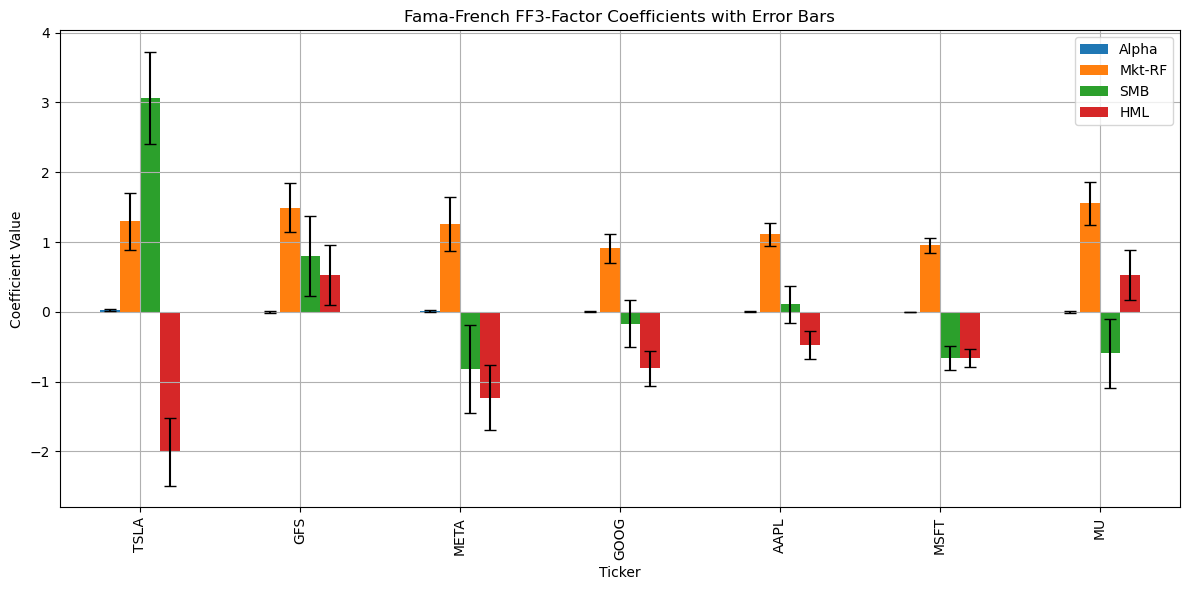

In [30]:
# Step 3: Generate Regression summary and Coefficients for Alpha, Mkt-RF, SMB, HML per Ticker
# Initialize lists
model_ff3,coef_df_ff3 = ff_regression_analysis(merged_data_ff3,'FF3')

In [31]:
# Step 4: Display FF3 Regression Parameters 
display_regression_parameters(coef_df_ff3,'FF3')


📊 FF3 Regression Parameters:


Ticker,TSLA,GFS,META,GOOG,AAPL,MSFT,MU
Alpha,0.0251,-0.0059,0.0126,0.0008,0.0015,-0.0014,-0.0088
Alpha_err,0.0195,0.0171,0.0186,0.0100,0.0078,0.0050,0.0145
Adj_R2,0.6004,0.3823,0.3019,0.4356,0.6045,0.7579,0.3928
Mkt-RF,1.2978,1.4942,1.2583,0.9126,1.1095,0.9521,1.5531
Mkt-RF_err,0.4049,0.3552,0.3878,0.2087,0.1626,0.1049,0.3024
SMB,3.0627,0.7997,-0.8137,-0.1703,0.1117,-0.6654,-0.5948
SMB_err,0.6598,0.5787,0.6319,0.3400,0.2649,0.1709,0.4926
HML,-2.0044,0.5264,-1.2330,-0.8059,-0.4741,-0.6633,0.5269
HML_err,0.4876,0.4277,0.4670,0.2513,0.1958,0.1263,0.3641


#### 📊 FF3 Regression Parameters Table

This table displays the **Fama-French 3-Factor (FF3) regression results** for each ticker in your dataset, including:

✅ **Alpha (Intercept):** The excess return unexplained by factor exposures, indicating potential outperformance or unexplained risks.

✅ **Factor Loadings:**
- `Mkt-RF`: Sensitivity to the market risk premium (market exposure).
- `SMB`: Sensitivity to the size factor (small-minus-big).
- `HML`: Sensitivity to the value factor (high-minus-low).

✅ **Standard Errors (`_err`):** Reflects the uncertainty of each estimated coefficient, providing insight into the precision of the regression estimates.

✅ **Adjusted R² (`Adj_R2`):** Shows how well the FF3 model explains the return variability for each ticker while adjusting for the number of factors included.

---

#### 🎨 Color Intensity:
The **blue gradient coloring** helps you:
- Quickly identify **high vs. low factor sensitivities across tickers**.
- Spot which assets are **more heavily influenced by specific factors**.
- Evaluate **model fit quality** (`Adj_R2`) across assets efficiently.

---

⚡ **Use cases:**
- Identify key factor exposures for each asset before portfolio construction.
- Compare factor loadings across tickers to spot unique exposures.
- Benchmark model fit before comparing to FF5, aiding decisions on whether the additional factors in FF5 are beneficial for your portfolio modeling.


### 📈 FF3 Actual vs. Fitted Excess Return per Ticker

This plot visualizes **how well the Fama-French 3-Factor (FF3) regression model fits the actual excess returns for each ticker** in your dataset.

---

✅ **What it shows:**

- **Blue scatter points:**  
  The **actual excess returns** plotted against `Mkt-RF` (market excess return) for each observation.

- **Red fitted line:**  
  The **predicted (fitted) excess returns** from your FF3 regression, based on the estimated factor exposures for the ticker.

- **Axes:**
  - X-axis: `Mkt-RF` (market excess return for the period).
  - Y-axis: Excess return of the asset above the risk-free rate.

- **Plot Title:** Includes the **ticker and the R² value** indicating model fit quality:
  - **High R²:** Fitted line closely follows the scatter.
  - **Low R²:** Greater deviation between actual and fitted values.

---

✅ **Why this is useful:**

- **Visual diagnostic tool** to assess how well the FF3 model explains returns for each ticker.
- Helps identify **tickers with poor model fit** (potentially needing alternative factor models or deeper investigation).
- Allows you to visually assess **outliers or nonlinear relationships** not captured by the linear FF3 model.
- Supports **intuitive validation** of your regression results before using them in optimization or deeper analysis.


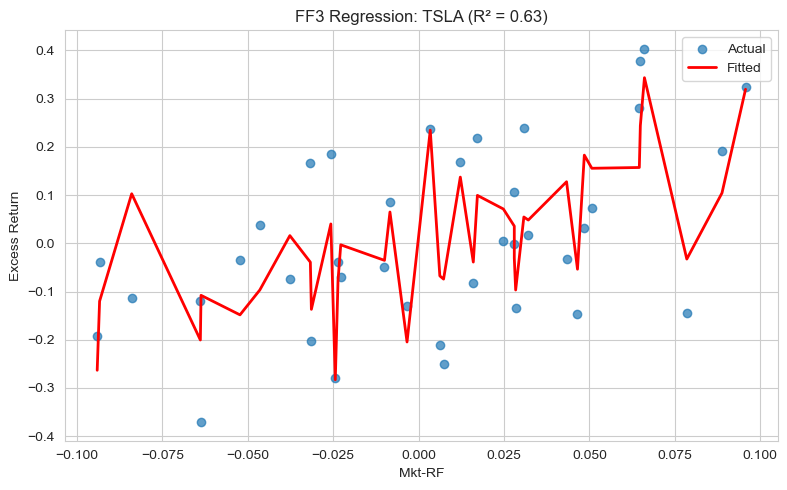

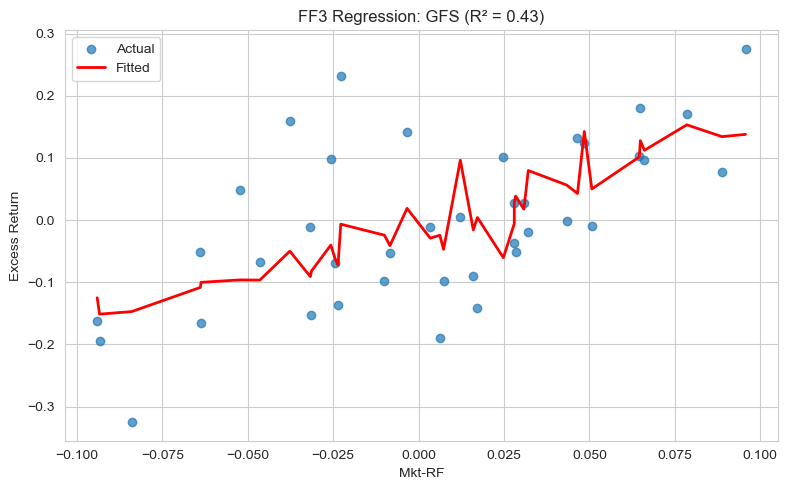

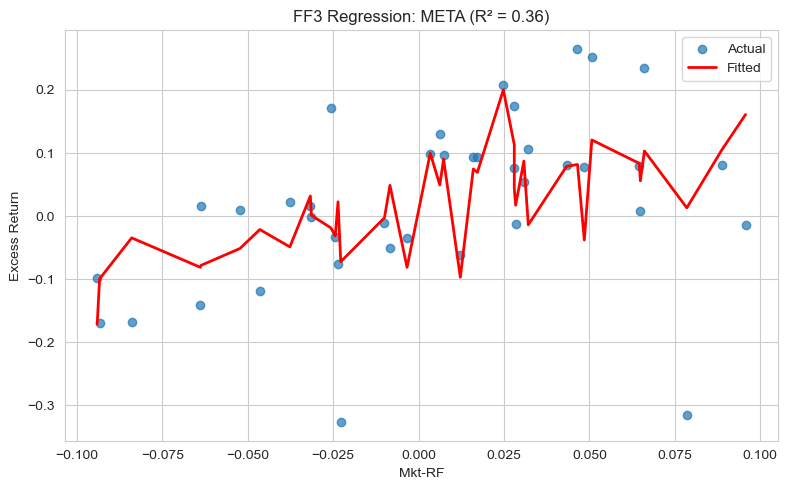

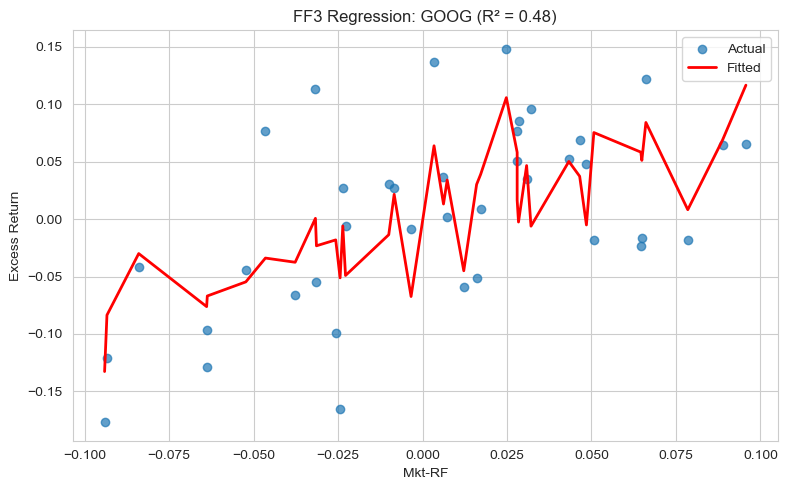

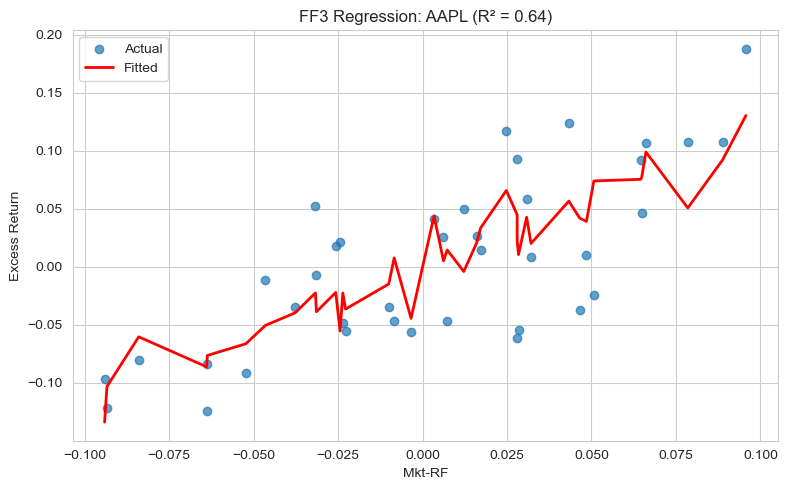

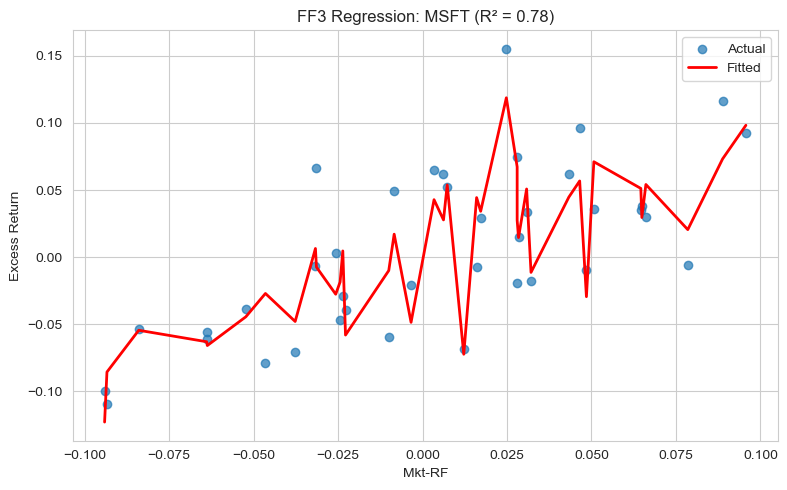

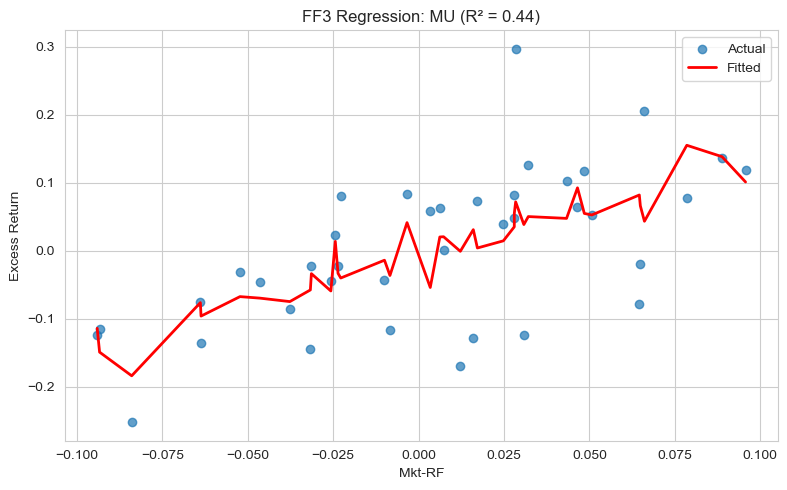

In [34]:
# Step 5: Plotting actual vs. fitted regression per ticker
ff_fitted_plt(merged_data_ff3, 'FF3')

## 5️⃣ 📊 FF5 Model
Run **Fama-French 5-Factor regression**, visualize coefficients, and generate summary statistics.

In [36]:
# Step 1: Load FF5 data 
ff5 = pd.read_csv('../data/ff_factors/F-F_Research_Data_5_Factors_2x3.csv', skiprows=3)
ff5.rename(columns={ff5.columns[0]: 'Date'}, inplace=True)
ff5 = ff5[ff5['Date'].astype(str).str.len() == 6]
ff5['Date'] = pd.to_datetime(ff5['Date'], format='%Y%m')

for col in ['Mkt-RF', 'SMB', 'HML','RMW','CMA','RF']:
    ff5[col] = ff5[col].astype(float) / 100

# ✅ Proper filtering using input dates
ff5 = ff5[(ff5['Date'] >= pd.to_datetime(start_date)) & (ff5['Date'] <= pd.to_datetime(end_date))]

### 📊 Fama-French 5-Factor Coefficients with Error Bars

This bar chart visualizes the **estimated factor loadings (coefficients) from your Fama-French 5-Factor (FF5) regression** for each ticker in your dataset.

---

✅ **What is displayed:**

- **X-axis:**  
  Tickers analyzed (e.g., MSFT, TSLA, GFS, GOOG, AAPL).

- **Y-axis:**  
  Estimated **factor loading values** (coefficient values).

- **Colored Bars:**  
  Each color represents a different FF5 factor:
  - 🟦 **Alpha:** Intercept (unexplained excess return).
  - 🟧 `Mkt-RF`: Market risk premium sensitivity.
  - 🟩 `SMB`: Size factor sensitivity.
  - 🟥 `HML`: Value factor sensitivity.
  - 🟪 `RMW`: Profitability factor sensitivity.
  - 🟫 `CMA`: Investment factor sensitivity.

- **Error Bars:**  
  Display the **standard errors** of each coefficient, indicating the **precision and uncertainty** of the estimates.

---

✅ **Why this is useful:**

- Quickly **compare factor exposures across tickers** to understand which factors significantly influence each asset.
- Identify **assets with high/low factor sensitivity** for targeted portfolio construction.
- Assess **estimation uncertainty visually** through error bars, helping determine if coefficients are statistically meaningful.
- Evaluate consistency across tickers for each factor to understand the dataset’s overall factor structure.

---

⚡ **Tip:** Use this plot before optimization to:
- Remove tickers with unstable estimates (large error bars relative to coefficient magnitude).
- Identify potential diversification opportunities based on differing factor exposures.




📊 FF5 Regression Summary for TSLA
                            OLS Regression Results                            
Dep. Variable:          Excess Return   R-squared:                       0.634
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                     11.45
Date:                Tue, 15 Jul 2025   Prob (F-statistic):           1.85e-06
Time:                        00:32:29   Log-Likelihood:                 30.214
No. Observations:                  39   AIC:                            -48.43
Df Residuals:                      33   BIC:                            -38.45
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.

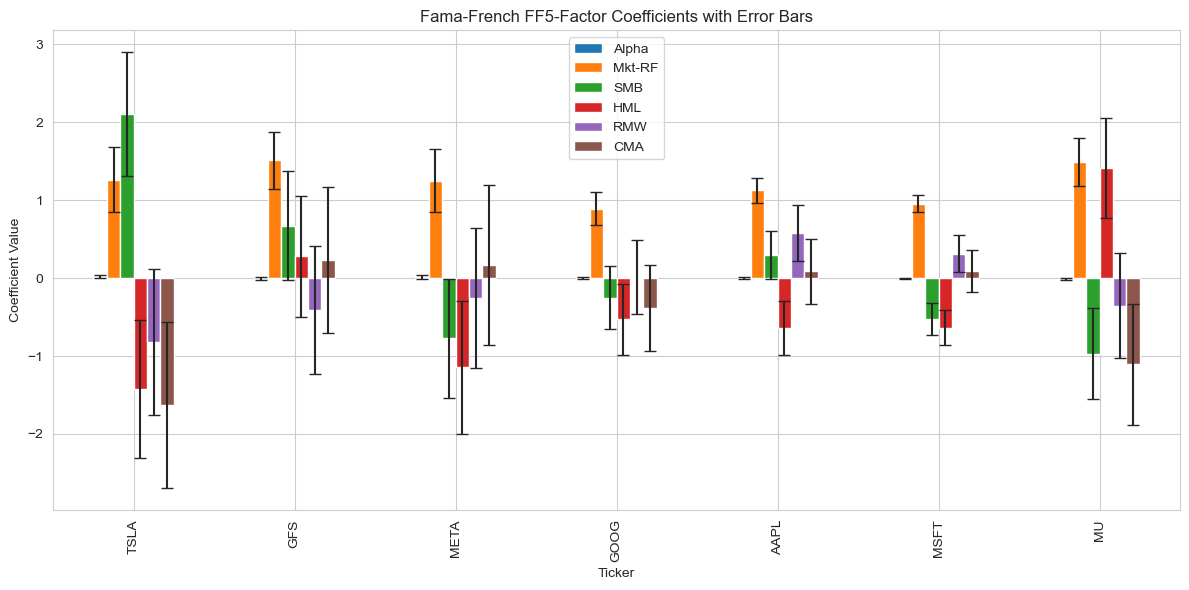

In [38]:
# Step 2: Processing Data for FF5
# Reset index and convert wide return table to long format
returns_reset = returns.reset_index()  # Date becomes a column
returns_melted = returns_reset.melt(id_vars='Date', var_name='Ticker', value_name='Return')

# Ensure 'Date' columns are datetime in both DataFrames
returns_melted['Date'] = pd.to_datetime(returns_melted['Date'])
ff5['Date'] = pd.to_datetime(ff5['Date'])

# Merge on 'Date'
merged_data_ff5 = pd.merge(returns_melted, ff5, on='Date', how='inner')

# Calculate excess return
merged_data_ff5['Excess Return'] = merged_data_ff5['Return'] - merged_data_ff5['RF']

#Summary for FF5
model,coef_df_ff5 = ff_regression_analysis(merged_data_ff5,'FF5')

In [39]:
#Display FF5 Regression Parameters
display_regression_parameters(coef_df_ff5,'FF5')


📊 FF5 Regression Parameters:


Ticker,TSLA,GFS,META,GOOG,AAPL,MSFT,MU
Alpha,0.0173,-0.0046,0.0145,-0.0008,0.0004,-0.0014,-0.0125
Alpha_err,0.0206,0.0181,0.0198,0.0106,0.0080,0.0052,0.0149
Adj_R2,0.5789,0.3469,0.2556,0.4094,0.6100,0.7564,0.3952
Mkt-RF,1.2612,1.5116,1.2489,0.8914,1.1256,0.9574,1.4895
Mkt-RF_err,0.4182,0.3674,0.4029,0.2148,0.1624,0.1059,0.3036
SMB,2.1035,0.6720,-0.7742,-0.2490,0.2929,-0.5233,-0.9677
SMB_err,0.7979,0.7010,0.7687,0.4098,0.3099,0.2020,0.5793
HML,-1.4221,0.2798,-1.1446,-0.5286,-0.6390,-0.6337,1.4193
HML_err,0.8841,0.7768,0.8517,0.4540,0.3434,0.2239,0.6418
RMW,-0.8196,-0.4079,-0.2520,0.0129,0.5770,0.3138,-0.3544


#### 📊 FF5 Regression Parameters Table

This table displays the **Fama-French 5-Factor (FF5) regression results** for each ticker in your dataset, including:

✅ **Alpha (Intercept):** Unexplained excess return after accounting for factor exposures.  
✅ **Factor Loadings:**  
- `Mkt-RF`: Market risk premium sensitivity  
- `SMB`: Size factor sensitivity  
- `HML`: Value factor sensitivity  
- `RMW`: Profitability factor sensitivity  
- `CMA`: Investment factor sensitivity

✅ **Standard Errors (`_err`):** Measures the uncertainty in each estimated coefficient, useful for understanding estimation precision.  
✅ **Adjusted R² (`Adj_R2`):** Indicates how well the model explains return variability while penalizing for additional factors.

#### 🎨 Color Intensity:
The **blue gradient** highlights the magnitude of each coefficient for **quick visual scanning**, allowing you to identify:
- **Strong factor exposures** across tickers
- **Relative magnitudes of factor sensitivities**
- How well the FF5 model fits different assets (`Adj_R2`)

---

⚡ **Use cases:**
- Identifying which factors significantly drive returns for each asset
- Assessing model fit quality before portfolio optimization
- Comparing with FF3 to evaluate the added explanatory power of FF5

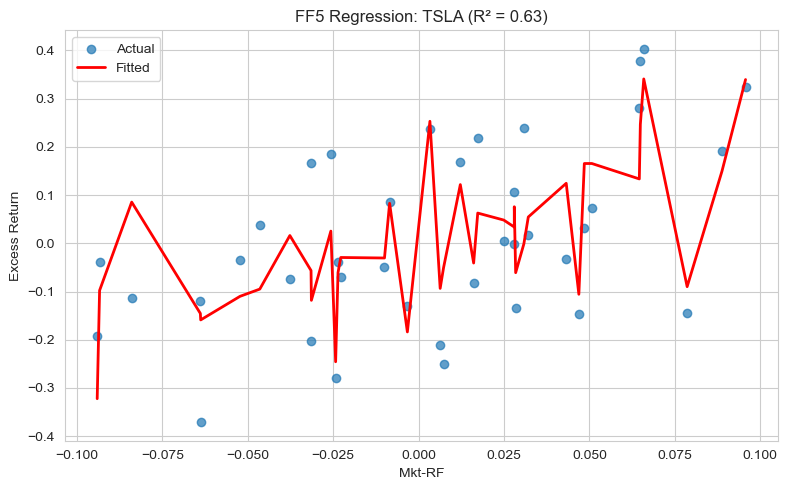

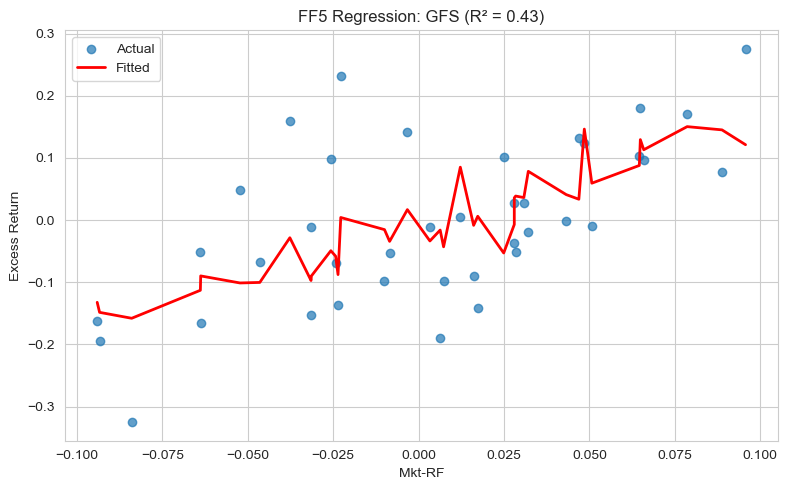

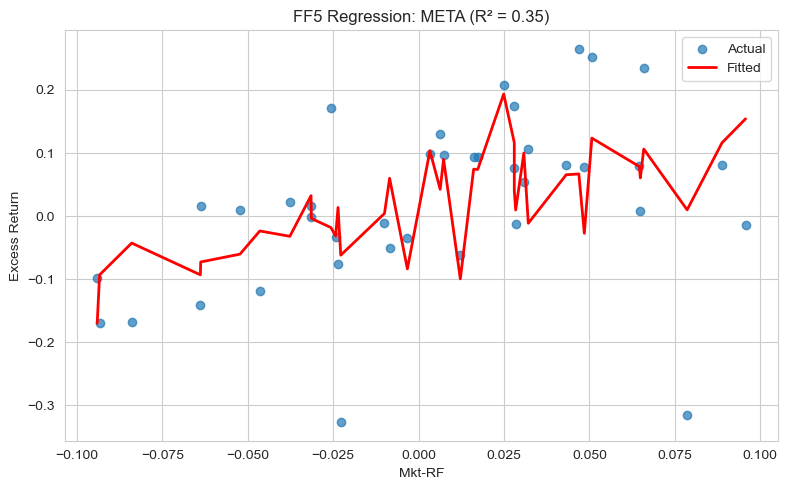

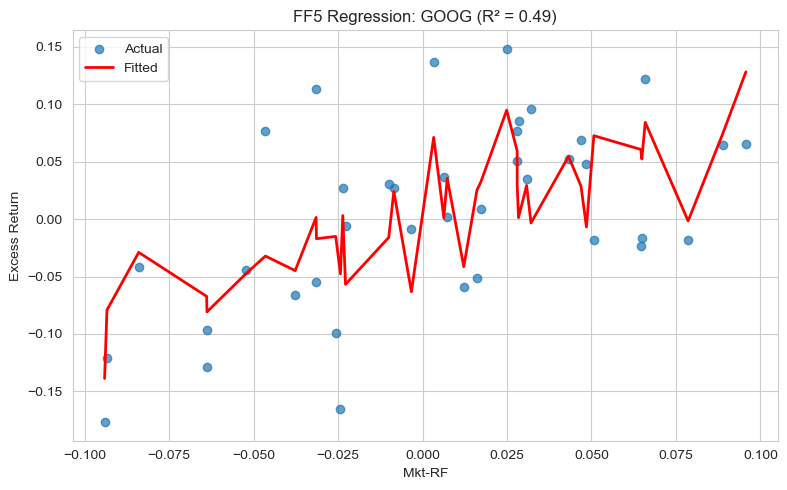

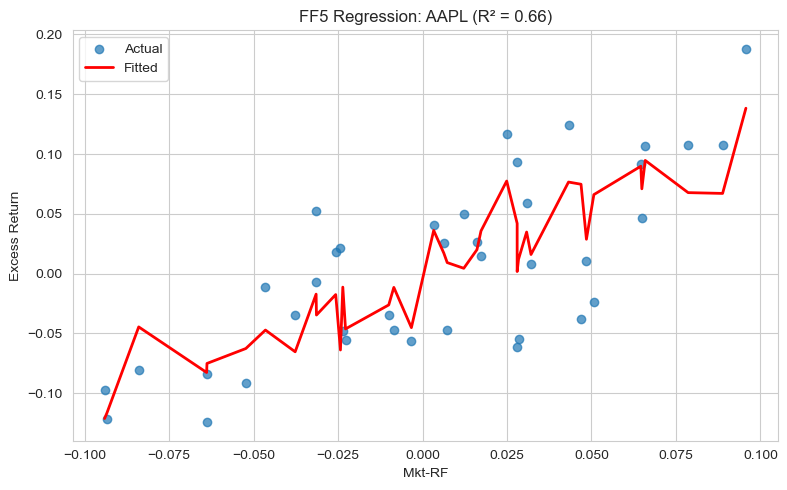

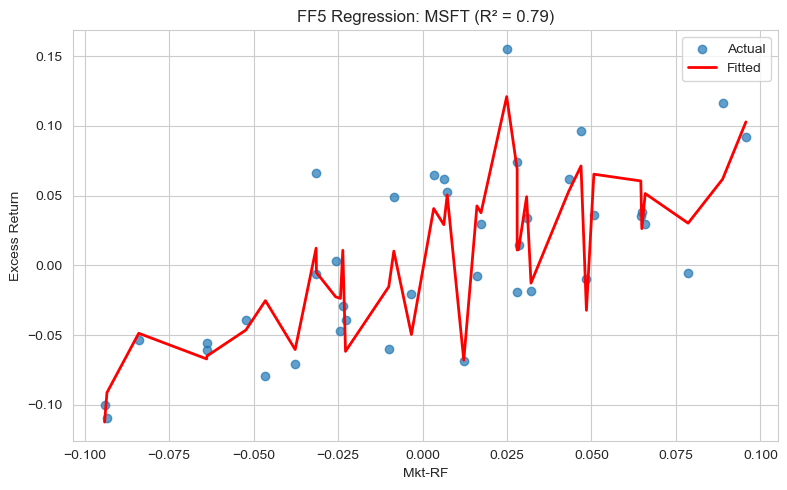

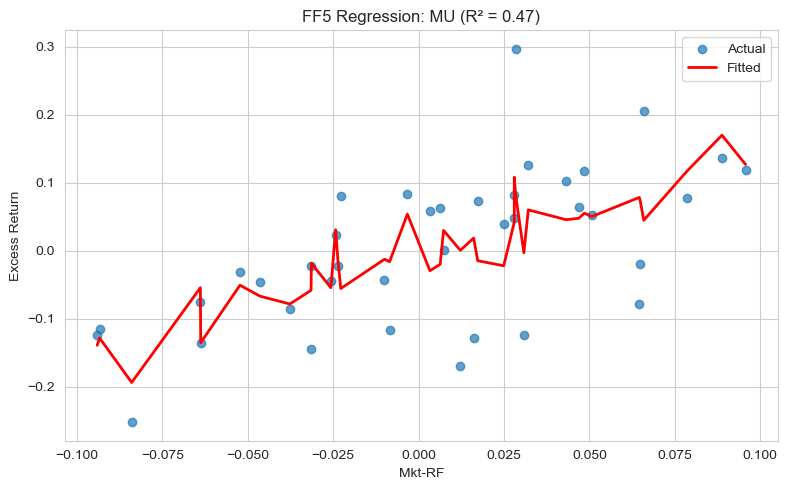

In [41]:
# Step 5: Plotting actual vs. fitted regression per ticker
ff_fitted_plt(merged_data_ff5, 'FF5')

#### 📈 FF5 Actual vs. Fitted Excess Return per Ticker

This plot visualizes **how well the Fama-French 5-Factor (FF5) regression model fits the actual excess returns for each ticker** in your dataset.

---

✅ **What it shows:**

- **Blue scatter points:**  
  The **actual excess returns** plotted against `Mkt-RF` (market excess return) for each observation.

- **Red fitted line:**  
  The **predicted (fitted) excess returns** from your FF5 regression, based on the estimated factor exposures for the ticker.

- **Axes:**
  - X-axis: `Mkt-RF` (market excess return for the period).
  - Y-axis: Excess return of the asset above the risk-free rate.

- **Plot Title:** Includes the **ticker and the R² value** indicating model fit quality:
  - **High R²:** Fitted line closely follows the scatter.
  - **Low R²:** Greater deviation between actual and fitted values.

---

✅ **Why this is useful:**

- **Visual diagnostic tool** to assess how well the FF3 model explains returns for each ticker.
- Helps identify **tickers with poor model fit** (potentially needing alternative factor models or deeper investigation).
- Allows you to visually assess **outliers or nonlinear relationships** not captured by the linear FF3 model.
- Supports **intuitive validation** of your regression results before using them in optimization or deeper analysis.


## 6️⃣ 🆚 FF3 vs. FF5 Comparison
Compare adjusted R², alpha reductions, and improvements between FF3 and FF5 models across tickers.

### 📊 FF3 vs FF5 Comparison: Adjusted R², Alpha, and Improvements

This section **compares the Fama-French 3-Factor (FF3) and 5-Factor (FF5) models** across your selected tickers, providing structured visual and tabular insights:



🔍 Comparing FF3 vs FF5 Models...

📈 Generating FF3 vs FF5 Comparison Summary...


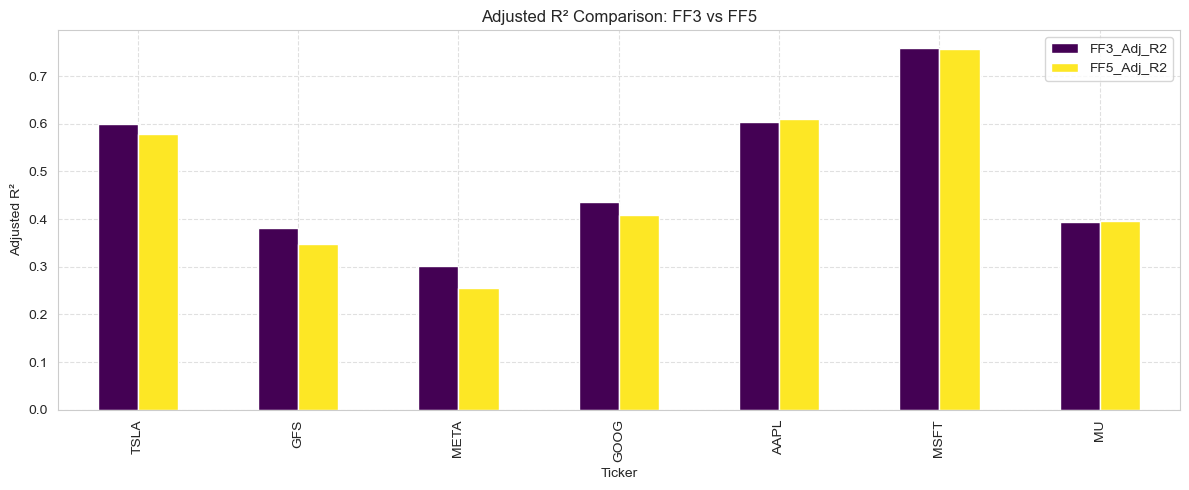

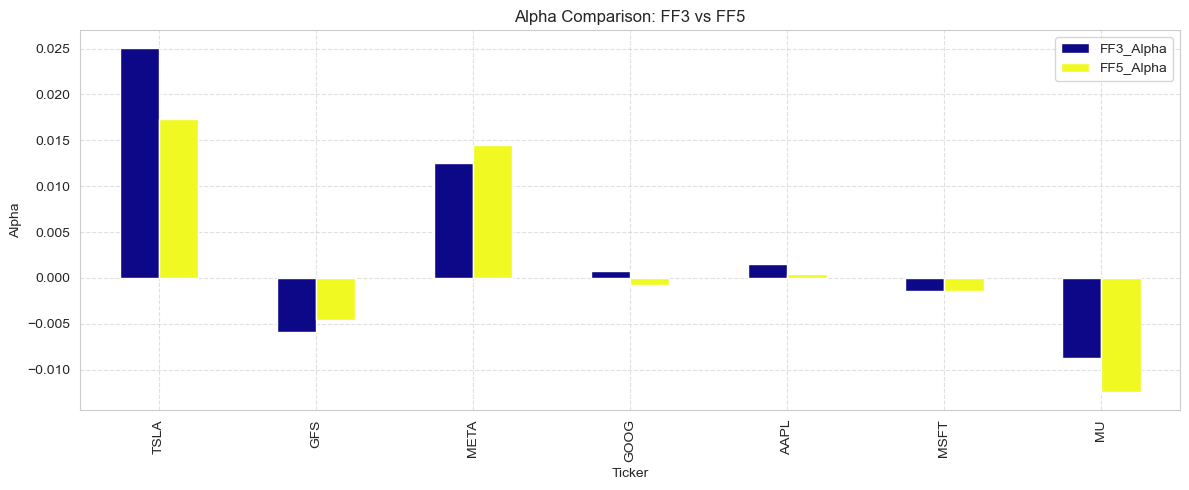

,FF3_Adj_R2,FF5_Adj_R2,R2_Improvement,R2_%_Improvement,FF3_Alpha,FF5_Alpha,Alpha_Reduction
Ticker,,,,,,,
TSLA,0.6004,0.5789,-0.0215,-3.5814,0.0251,0.0173,-0.0078
GFS,0.3823,0.3469,-0.0353,-9.2462,-0.0059,-0.0046,0.0013
META,0.3019,0.2556,-0.0462,-15.3185,0.0126,0.0145,0.0020
GOOG,0.4356,0.4094,-0.0262,-6.0061,0.0008,-0.0008,-0.0016
AAPL,0.6045,0.6100,0.0055,0.9055,0.0015,0.0004,-0.0011
MSFT,0.7579,0.7564,-0.0015,-0.2008,-0.0014,-0.0014,0.0000
MU,0.3928,0.3952,0.0024,0.6080,-0.0088,-0.0125,-0.0037


In [45]:
# 🚩 Comparing FF3 vs FF5: Adjusted R² and Alpha via structured analysis and visualization
print("\n🔍 Comparing FF3 vs FF5 Models...")
comparison_df = compare_ff3_ff5(coef_df_ff3, coef_df_ff5)

#### 1️⃣ Adjusted R² Comparison
- **Bar Chart** comparing the `Adjusted R²` values between FF3 and FF5 for each ticker.
- **Interpretation**:
  - **Higher `Adjusted R²`** indicates a better model fit for explaining excess returns.
  - Helps determine if adding factors in FF5 improves explanatory power.

---

#### 2️⃣ Alpha Comparison
- **Bar Chart** comparing `Alpha` between FF3 and FF5 for each ticker.
- **Interpretation**:
  - Shows if alpha reduces when using FF5, indicating whether additional factors account for previously unexplained returns.

---

#### 🪄 3️⃣ Summary Table

A **styled summary table** displaying:

| Metric | Description |
|-------|------------|
| **FF3_Adj_R2 / FF5_Adj_R2** | Adjusted R² under FF3 and FF5 |
| **R2_Improvement** | Absolute change in Adjusted R² (FF5 - FF3) |
| **R2_%_Improvement** | % improvement in Adjusted R² |
| **FF3_Alpha / FF5_Alpha** | Estimated Alpha under FF3 and FF5 |
| **Alpha_Reduction** | Change in Alpha (FF5 - FF3) |

✅ **Color gradients** in the table help you quickly identify:
- Improvements in model fit (**R²**).
- Reduction in Alpha with FF5.
- Tickers where FF5 provides significant benefits.

---

#### 💡 Why This is Useful:
✅ Identify whether moving from FF3 to FF5 materially improves model fit for your assets.  
✅ See if adding Profitability (`RMW`) and Investment (`CMA`) factors reduces unexplained returns (`Alpha`).  
✅ Support decision-making on which factor model to adopt for **portfolio optimization and risk analysis**.

### 🔍 FF3 vs FF5 Improvement Summary

This section **visualizes and summarizes how moving from FF3 to FF5 impacts your model fit across selected tickers**.

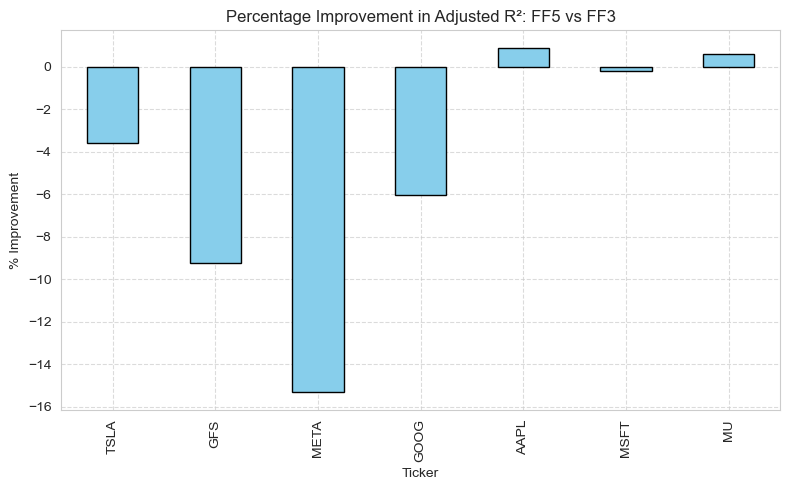

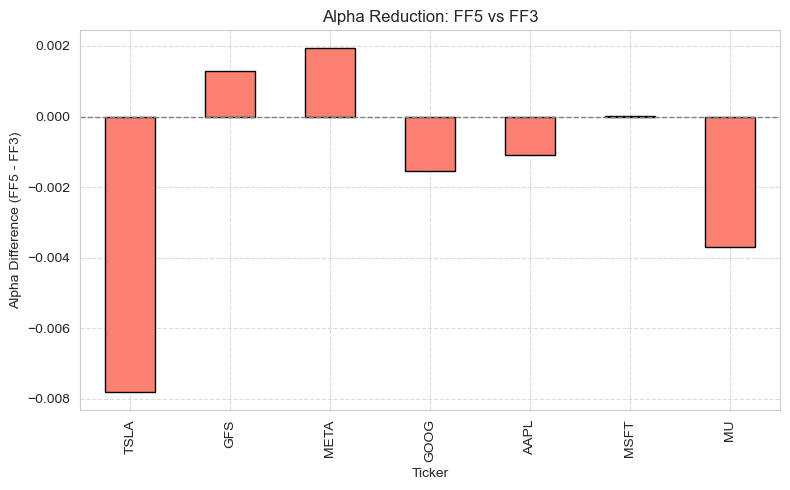


📊 Summary Interpretation:
TSLA: Adj R² improved by -3.58% and Alpha reduced by -0.00782.
GFS: Adj R² improved by -9.25% and Alpha reduced by 0.00130.
META: Adj R² improved by -15.32% and Alpha reduced by 0.00195.
GOOG: Adj R² improved by -6.01% and Alpha reduced by -0.00155.
AAPL: Adj R² improved by 0.91% and Alpha reduced by -0.00109.
MSFT: Adj R² improved by -0.20% and Alpha reduced by 0.00000.
MU: Adj R² improved by 0.61% and Alpha reduced by -0.00371.


In [48]:
# Summary for FF3 vs. FF5 Model
analyze_ff3_ff5_comparison(comparison_df)

#### 1️⃣ Percentage Improvement in Adjusted R²
- **Bar Chart** showing `% improvement in Adjusted R²` (FF5 vs FF3) for each ticker.
- Interpretation:
  - **Positive values** indicate better explanatory power when using FF5.
  - **Negative values** suggest FF5 may not improve fit over FF3 for that ticker.

---

#### 2️⃣ Alpha Reduction: FF5 vs FF3
- **Bar Chart** showing the change in Alpha (`FF5 Alpha - FF3 Alpha`) for each ticker.
- Interpretation:
  - **Negative values** indicate **Alpha is reduced using FF5**, suggesting additional factors (RMW, CMA) help explain returns.
  - **Near-zero or positive values** suggest FF5 does not materially reduce unexplained returns.

---

#### 📝 Summary Interpretation


## 7️⃣ 💼 Portfolio Optimization
Optimize portfolio weights using the selected model based on **expected returns, factor exposures, risk aversion, and covariance structures**.

### 📊 Portfolio Optimization Comparison: FF3 vs FF5 Models
This section compares optimized portfolio allocations using FF3 vs FF5 on your selected tickers with the same risk aversion for direct comparison.


🎯 Risk Aversion Level (higher = more conservative):
 - 1–5   ➜ Aggressive (maximize returns)
 - 10–20 ➜ Balanced (moderate risk-return trade-off)
 - 30+   ➜ Conservative (prefer low volatility)


Enter your risk aversion level (e.g., 10): 10

Calculate Optimize Portfolio Using FF3 Model? (y/n):  y
Calculate for long-term mean factor premium for FF3? (y/n):  n



✅ Optimized Portfolio Weights (FF3):
  Ticker  Weight (%)
0   AAPL       20.46
1    GFS        0.00
2   GOOG       24.35
3   META        5.93
4   MSFT       48.69
5     MU        0.00
6   TSLA        0.57


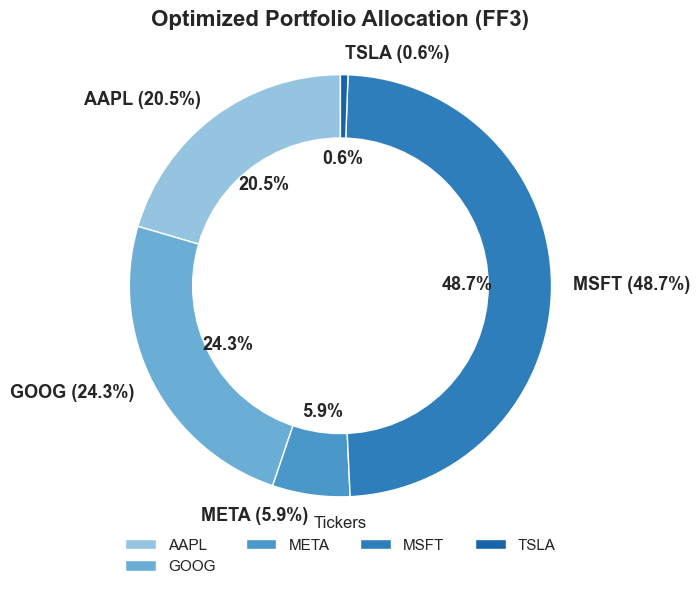


Calculate Optimize Portfolio Using FF5 Model? (y/n):  y
Calculate for long-term mean factor premium for FF5? (y/n):  n



✅ Optimized Portfolio Weights (FF5):
  Ticker  Weight (%)
0   AAPL        0.00
1    GFS        0.00
2   GOOG       35.65
3   META       10.07
4   MSFT       47.84
5     MU        0.00
6   TSLA        6.44


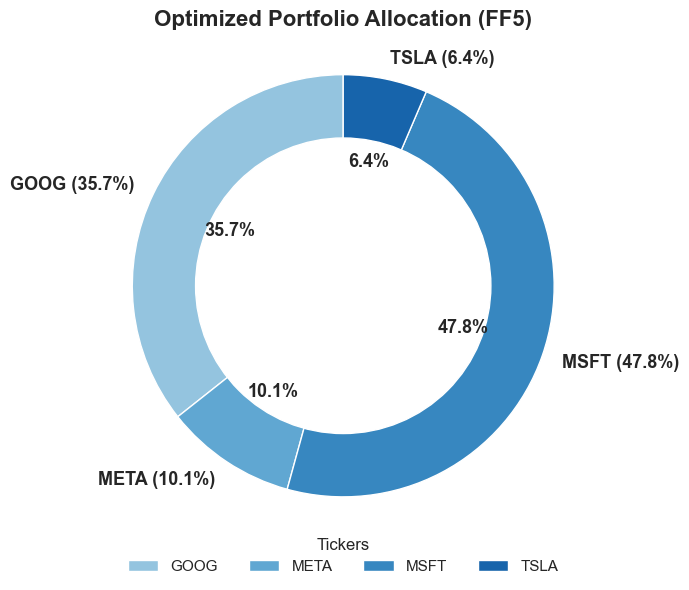

In [52]:
# 🚩 Portfolio Optimization using FF3 and FF5 Models
if len(tickers) > 1:
    # 🎯 Risk Aversion Input
    print("\n🎯 Risk Aversion Level (higher = more conservative):")
    print(" - 1–5   ➜ Aggressive (maximize returns)")
    print(" - 10–20 ➜ Balanced (moderate risk-return trade-off)")
    print(" - 30+   ➜ Conservative (prefer low volatility)")

    try:
        risk_aversion = float(input("Enter your risk aversion level (e.g., 10):").strip())
    except ValueError:
        print("❌ Invalid input. Using default: 10")
        risk_aversion = 10

    # ✅ FF3 Optimization
    run_ff3 = input("\nCalculate Optimize Portfolio Using FF3 Model? (y/n): ").strip().lower()
    if run_ff3 == 'y':
        long_term = input('Calculate for long-term mean factor premium for FF3? (y/n): ').strip().lower() == 'y'

        factor_premiums_ff3 = (
            merged_data_ff3[['Mkt-RF', 'SMB', 'HML']].mean()
            if long_term else
            merged_data_ff3[['Mkt-RF', 'SMB', 'HML']].iloc[-1]
        )

        tickers_sorted = sorted(coef_df_ff3.columns)
        coef_df_ff3_sorted = coef_df_ff3[tickers_sorted]

        alpha = coef_df_ff3_sorted.T['Alpha'].values
        beta_mkt = coef_df_ff3_sorted.T['Mkt-RF'].values
        beta_smb = coef_df_ff3_sorted.T['SMB'].values
        beta_hml = coef_df_ff3_sorted.T['HML'].values

        expected_excess_return_ff3 = (
            alpha +
            beta_mkt * factor_premiums_ff3['Mkt-RF'] +
            beta_smb * factor_premiums_ff3['SMB'] +
            beta_hml * factor_premiums_ff3['HML']
        )

        cov_matrix_ff3 = returns[tickers_sorted].cov().values

        portfolio_weights_ff3 = optimize_portfolio(
            expected_excess_return_ff3,
            cov_matrix_ff3,
            tickers_sorted,
            risk_aversion
        )

        portfolio_weights_ff3['Weight (%)'] = (portfolio_weights_ff3['Weight'] * 100).round(2)
        print("\n✅ Optimized Portfolio Weights (FF3):")
        print(portfolio_weights_ff3[['Ticker', 'Weight (%)']])

        plot_portfolio_pie(portfolio_weights_ff3, "FF3")

    else:
        print("⚠️ Pass FF3 Portfolio Optimization.")

    # ✅ FF5 Optimization
    run_ff5 = input("\nCalculate Optimize Portfolio Using FF5 Model? (y/n): ").strip().lower()
    if run_ff5 == 'y':
        long_term = input('Calculate for long-term mean factor premium for FF5? (y/n): ').strip().lower() == 'y'

        factor_premiums_ff5 = (
            merged_data_ff5[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']].mean()
            if long_term else
            merged_data_ff5[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']].iloc[-1]
        )

        tickers_sorted = sorted(coef_df_ff5.columns)
        coef_df_ff5_sorted = coef_df_ff5[tickers_sorted]

        alpha = coef_df_ff5_sorted.T['Alpha'].values
        beta_mkt = coef_df_ff5_sorted.T['Mkt-RF'].values
        beta_smb = coef_df_ff5_sorted.T['SMB'].values
        beta_hml = coef_df_ff5_sorted.T['HML'].values
        beta_rmw = coef_df_ff5_sorted.T['RMW'].values
        beta_cma = coef_df_ff5_sorted.T['CMA'].values

        expected_excess_return_ff5 = (
            alpha +
            beta_mkt * factor_premiums_ff5['Mkt-RF'] +
            beta_smb * factor_premiums_ff5['SMB'] +
            beta_hml * factor_premiums_ff5['HML'] +
            beta_rmw * factor_premiums_ff5['RMW'] +
            beta_cma * factor_premiums_ff5['CMA']
        )

        cov_matrix_ff5 = returns[tickers_sorted].cov().values

        portfolio_weights_ff5 = optimize_portfolio(
            expected_excess_return_ff5,
            cov_matrix_ff5,
            tickers_sorted,
            risk_aversion
        )

        portfolio_weights_ff5['Weight (%)'] = (portfolio_weights_ff5['Weight'] * 100).round(2)
        print('\n✅ Optimized Portfolio Weights (FF5):')
        print(portfolio_weights_ff5[['Ticker', 'Weight (%)']])

        plot_portfolio_pie(portfolio_weights_ff5,'FF5')

    else:
        print('⚠️ Pass FF5 Portfolio Optimization.')

else:
    print('⚠️ Not enough tickers to perform optimization.')


#### 📝 Notes on FF3 vs FF5 Portfolio Optimization

✅ **Using recent factor premiums:**

- The **FF5 model includes RMW (Profitability) and CMA (Investment)** factors, which can influence expected returns and optimized weights.
- This can lead to **different portfolio allocations under FF5** compared to FF3, reflecting the additional factor exposures.

✅ **Using long-term mean (averages over your timeframe):**

- The **RMW and CMA factors typically average near zero (~0.0001–0.0003 monthly)** over long periods.
- As a result, **their impact on expected returns becomes negligible**, and **FF5 optimization results will closely match FF3 outcomes** when using long-term means.

✅ **To effectively observe differences between FF3 and FF5:**

- Use **recent factor premiums** instead of long-term averages.
- Select **tickers with high RMW and CMA exposures** (e.g., small-cap or high-profitability stocks) to highlight the influence of these factors.
- Consider **shorter timeframes (12–24 months)** or **rolling windows** to capture periods where RMW and CMA significantly affect expected returns and portfolio weights.


In [54]:
# FF3 Portfolio Returns
portfolio_returns_ff3 = compute_portfolio_returns(portfolio_weights_ff3, returns) \
    if 'portfolio_weights_ff3' in locals() else None

# FF5 Portfolio Returns
portfolio_returns_ff5 = compute_portfolio_returns(portfolio_weights_ff5, returns) \
    if 'portfolio_weights_ff5' in locals() else None

Benchmark with S&P500 for backtesting? (y/n):  y


[*********************100%***********************]  1 of 1 completed
C:\Users\wiell\AppData\Local\Temp\ipykernel_13320\3244902432.py:60: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\wiell\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


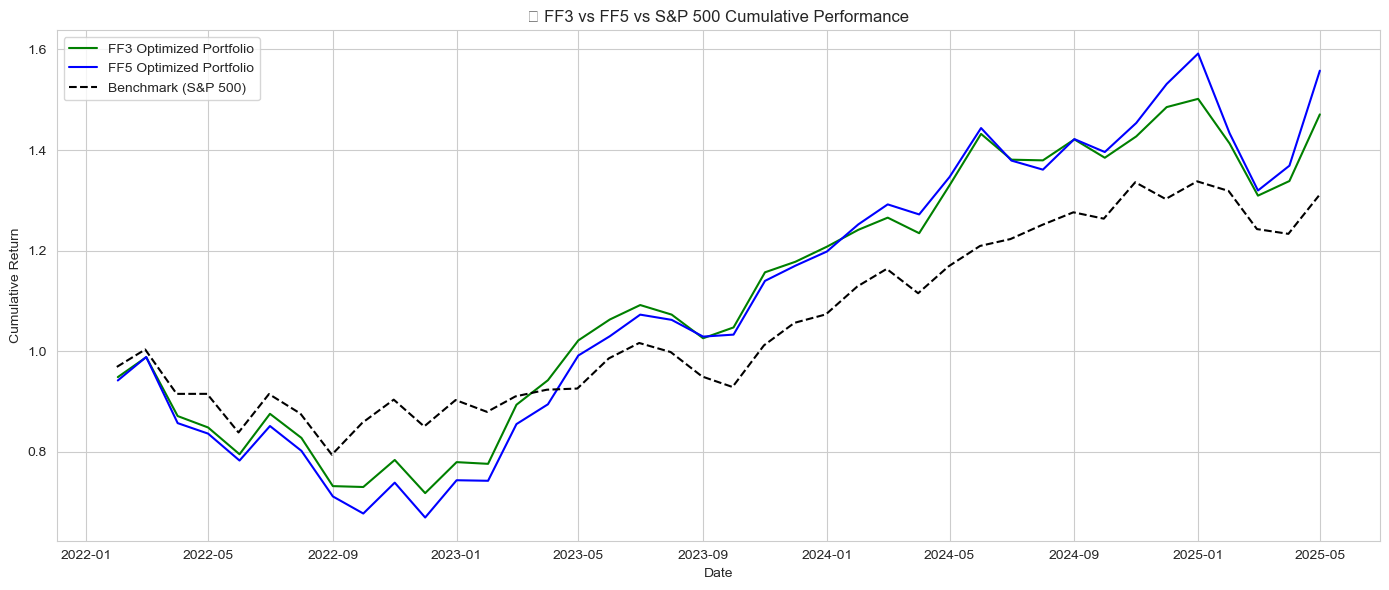

In [55]:
#Backtesting Portfolio with Optional S&P 500 Benchmark

# ✅ User prompt for benchmark inclusion
use_benchmark = input('Benchmark with S&P500 for backtesting? (y/n): ').strip().lower() == 'y'

# ✅ Compute FF3 Portfolio Returns if available
portfolio_returns_ff3 = compute_portfolio_returns(portfolio_weights_ff3, returns) \
    if 'portfolio_weights_ff3' in locals() else None

# ✅ Compute FF5 Portfolio Returns if available
portfolio_returns_ff5 = compute_portfolio_returns(portfolio_weights_ff5, returns) \
    if 'portfolio_weights_ff5' in locals() else None

# ✅ Compute cumulative returns for available portfolios
cum_ff3 = compute_cumulative_returns(portfolio_returns_ff3) if portfolio_returns_ff3 is not None else None
cum_ff5 = compute_cumulative_returns(portfolio_returns_ff5) if portfolio_returns_ff5 is not None else None

# ✅ If benchmark selected, download and compute benchmark returns
if use_benchmark:
    snp = yf.download('^GSPC', start=start_date, end=end_date, interval='1d', auto_adjust=True)
    snp_monthly = snp['Close'].resample('ME').last()
    snp_returns = snp_monthly.pct_change().shift(-1).dropna()
    snp_returns.name = 'S&P 500'
    cum_bench = compute_cumulative_returns(snp_returns)
else:
    cum_bench = None

# ✅ Plot results
plt.figure(figsize=(14, 6))

if cum_ff3 is not None:
    plt.plot(cum_ff3, label='FF3 Optimized Portfolio', color='green')

if cum_ff5 is not None:
    plt.plot(cum_ff5, label='FF5 Optimized Portfolio', color='blue')

if cum_bench is not None:
    plt.plot(cum_bench, label='Benchmark (S&P 500)', color='black', linestyle='--')

# ✅ Dynamic title based on availability
if cum_bench is not None and cum_ff3 is not None and cum_ff5 is not None:
    plt.title('📈 FF3 vs FF5 vs S&P 500 Cumulative Performance')
elif cum_bench is not None and cum_ff3 is not None:
    plt.title('📈 FF3 vs S&P 500 Cumulative Performance')
elif cum_bench is not None and cum_ff5 is not None:
    plt.title('📈 FF5 vs S&P 500 Cumulative Performance')
elif cum_ff3 is not None and cum_ff5 is not None:
    plt.title('📈 FF3 vs FF5 Cumulative Performance')
elif cum_ff3 is not None:
    plt.title('📈 FF3 Cumulative Performance')
elif cum_ff5 is not None:
    plt.title('📈 FF5 Cumulative Performance')
else:
    plt.title('⚠️ No Portfolio Data Available for Plotting')

plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\wiell\AppData\Local\Temp\ipykernel_13320\2908735509.py:57: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()


📊 FF3 Optimized Portfolio Drawdown Duration Analysis
   • Max Drawdown Duration   : 13 months
   • Average Drawdown Duration: 5.20 months

📊 FF5 Optimized Portfolio Drawdown Duration Analysis
   • Max Drawdown Duration   : 13 months
   • Average Drawdown Duration: 5.00 months

📊 Benchmark (S&P 500) Drawdown Duration Analysis
   • Max Drawdown Duration   : 15 months
   • Average Drawdown Duration: 4.33 months



C:\Users\wiell\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


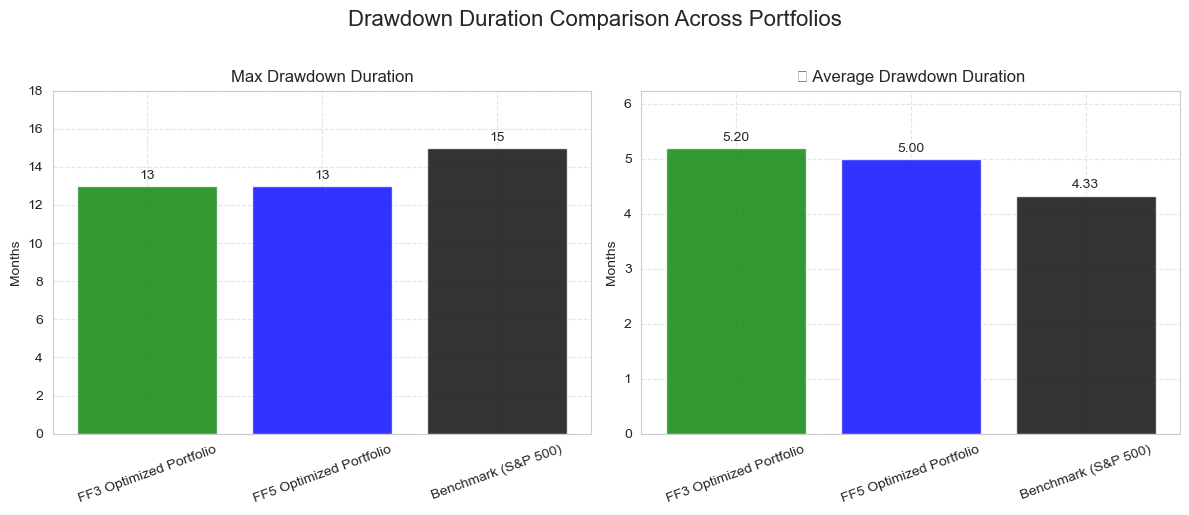

In [56]:
dd_results = []

if cum_ff3 is not None:
    dd_results.append(calculate_drawdown_duration(cum_ff3, label="FF3 Optimized Portfolio"))

# FF5
if cum_ff5 is not None:
    dd_results.append(calculate_drawdown_duration(cum_ff5, label="FF5 Optimized Portfolio"))

# Benchmark
if cum_bench is not None:
    dd_results.append(calculate_drawdown_duration(cum_bench, label="Benchmark (S&P 500)"))
dd_df = pd.DataFrame(dd_results, columns=["Model", "Max Drawdown Duration (months)", "Avg Drawdown Duration (months)"])

plot_drawdown_duration_comparison(dd_df)

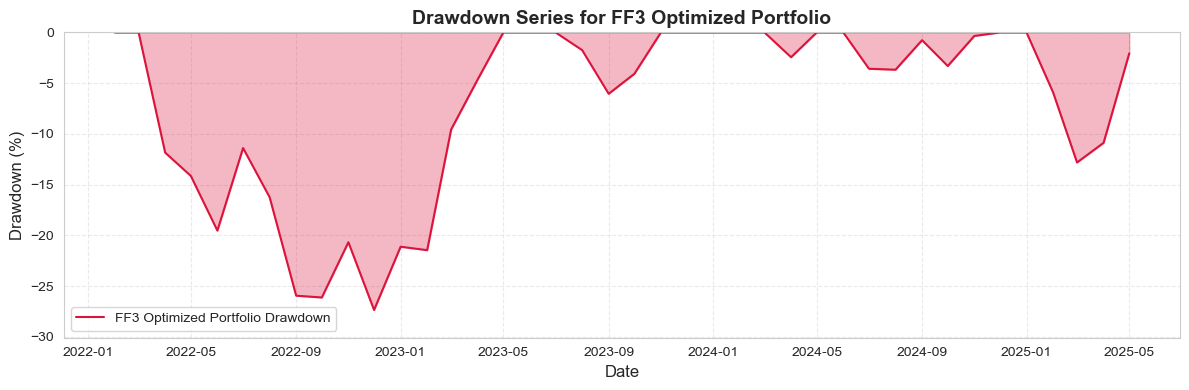

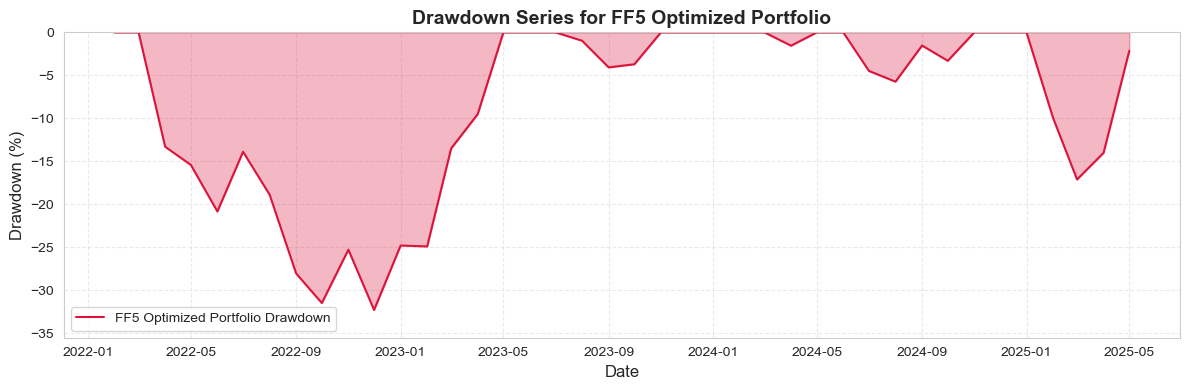

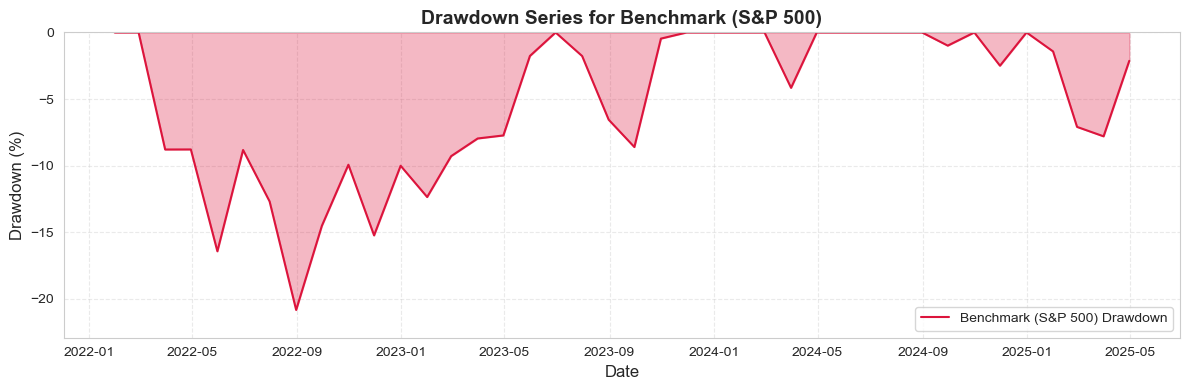

In [57]:
# ✅ Safe drawdown plotting block with conditional checks

# FF3 Drawdown
if 'cum_ff3' in locals() and cum_ff3 is not None:
    plot_drawdown_series(cum_ff3, label='FF3 Optimized Portfolio')
else:
    print("⚠️ FF3 cumulative returns not available, skipping FF3 drawdown plot.")

# FF5 Drawdown
if 'cum_ff5' in locals() and cum_ff5 is not None:
    plot_drawdown_series(cum_ff5, label='FF5 Optimized Portfolio')
else:
    print("⚠️ FF5 cumulative returns not available, skipping FF5 drawdown plot.")

# Benchmark Drawdown
if 'cum_bench' in locals() and cum_bench is not None:
    plot_drawdown_series(cum_bench, label='Benchmark (S&P 500)')
else:
    print("⚠️ Benchmark cumulative returns not available, skipping benchmark drawdown plot.")


#### 📉 Drawdown Duration Comparison Across Portfolios

The chart below compares **maximum drawdown duration** and **average drawdown duration** across:

✅ **FF3 Optimized Portfolio** (Green)  
✅ **FF5 Optimized Portfolio** (Blue)  
✅ **Benchmark (S&P 500)** (Black)

**Key Insights:**
- These metrics help evaluate **liquidity risks and investor psychological thresholds** during downturn periods when using factor-based portfolio optimization.

**Key Things:**

- Prolonged drawdown durations can impact **client expectations and fund flows**, even when overall CAGR and Sharpe remain attractive.
- Helps refine rebalancing strategies and potential hedging overlay to shorten recovery periods in live implementation.

Enter your risk-free rate (default = 0.03):  0.03


,FF3 Optimized Portfolio
CAGR,12.27
Volatility,21.66
Sharpe Ratio,0.59
Sortino Ratio,1.12
Max Drawdown,-27.36
Calmar Ratio,0.45


,FF5 Optimized Portfolio
CAGR,14.22
Volatility,24.08
Sharpe Ratio,0.64
Sortino Ratio,1.21
Max Drawdown,-32.30
Calmar Ratio,0.44


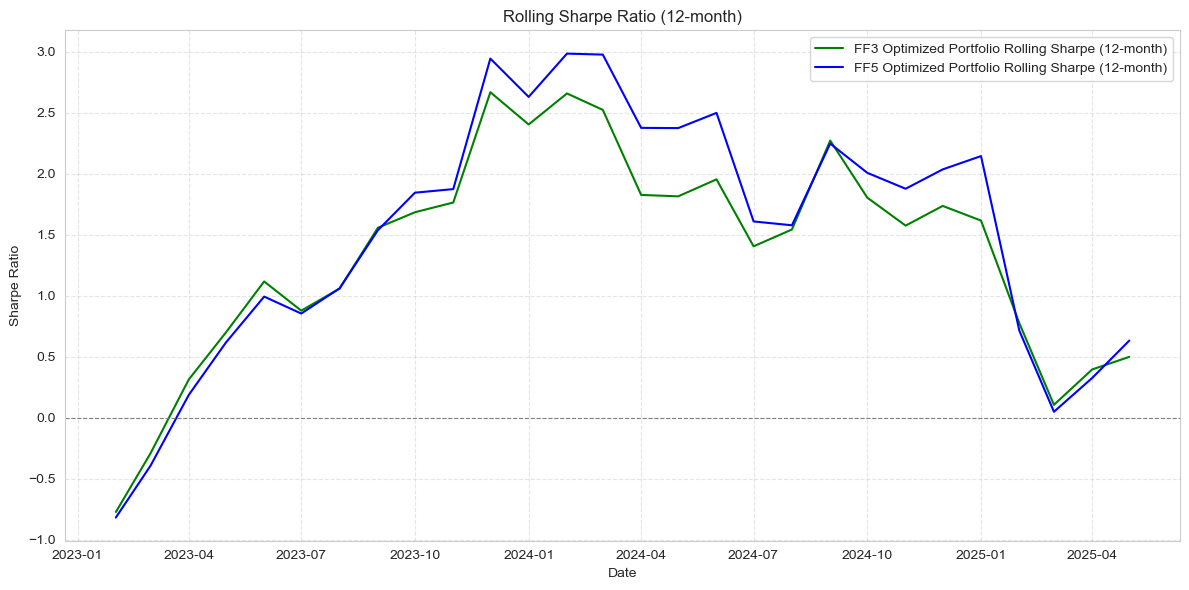

In [59]:
# 🚀 Extend FF3 and FF5 metrics table with user input for risk-free rate
# Get user input safely with default fallback
try:
    risk_free_rate = float(input("Enter your risk-free rate (default = 0.03): ") or 0.03)
except ValueError:
    print("Invalid input. Using default risk-free rate = 0.03")
    risk_free_rate = 0.03

# Compute metrics with the provided risk-free rate
ff3_metrics = calculate_performance_metrics(cum_ff3, risk_free_rate=risk_free_rate)
ff5_metrics = calculate_performance_metrics(cum_ff5, risk_free_rate=risk_free_rate)

# Display cleanly
display(ff3_metrics.to_frame(name='FF3 Optimized Portfolio'))
display(ff5_metrics.to_frame(name='FF5 Optimized Portfolio'))

# Rolling Sharpe plots
plot_rolling_sharpe_auto(risk_free_rate)

#### Explanation of Metrics

**1️⃣ CAGR (Compound Annual Growth Rate)**  
Measures the mean annual growth rate of the portfolio, assuming profits are reinvested. Higher CAGR indicates stronger long-term returns.

**2️⃣ Volatility**  
Represents the annualized standard deviation of returns, indicating how much the portfolio's returns deviate from the mean. Higher volatility means higher risk.

**3️⃣ Sharpe Ratio**  
Calculates excess return per unit of total risk (volatility), using the formula:
\[
\text{Sharpe Ratio} = \frac{\text{Portfolio Return} - \text{Risk-Free Rate}}{\text{Volatility}}
\]
Higher values indicate better risk-adjusted returns.

**4️⃣ Sortino Ratio**  
Similar to Sharpe but only penalizes downside volatility (negative returns). Useful for understanding risk-adjusted returns focusing on downside risk.

**5️⃣ Max Drawdown**  
Measures the maximum observed loss from a peak to a trough before a new peak is attained. Indicates worst-case scenario for capital erosion.

**6️⃣ Calmar Ratio**  
Calculated as:
\[
\text{Calmar Ratio} = \frac{\text{CAGR}}{\lvert \text{Max Drawdown} \rvert}
\]
A higher Calmar Ratio indicates better return relative to the worst drawdown experienced.

---

#### ⚙️ What This Code Is Doing

✅ **Takes your optimized portfolio returns (FF3 and FF5)**  
✅ **Calculates performance metrics (CAGR, Volatility, Sharpe, Sortino, Max Drawdown, Calmar) automatically** using your input risk-free rate (default = 3%).  
✅ **Plots 12-month Rolling Sharpe Ratios** to visualize how risk-adjusted returns evolve over time for both FF3 and FF5 optimized portfolios.  
✅ **Helps compare stability, drawdown resilience, and consistency of FF3 vs FF5 portfolios**, supporting better portfolio model selection.

---

#### 🗝️ Why This Is Useful

🔹 Allows **clear, systematic comparison** of FF3 and FF5 optimized strategies.  
🔹 Understand trade-offs between higher returns vs. higher volatility and drawdowns.  
🔹 Rolling Sharpe visualization helps identify periods of underperformance and outperformance dynamically.  
🔹 Equips you with quantitative insights to **iterate, refine, and justify your factor model portfolio decisions** in research and practical investment workflows.


## 8️⃣ 💾 Save Output
Save optimized portfolio weights, regression summaries, and comparison tables for reporting or further analysis.

In [62]:
# Ask user whether to save outputs
if input("Save all outputs to CSV in Data/output/? (y/n): ").strip().lower() == 'y':

    # List of potential outputs to save with friendly names
    outputs = {
        "merged_data_ff3.csv": "merged_data_ff3",
        "merged_data_ff5.csv": "merged_data_ff5",
        "coef_df_ff3.csv": "coef_df_ff3",
        "coef_df_ff5.csv": "coef_df_ff5",
        "portfolio_weights_ff3.csv": "portfolio_weights_ff3",
        "portfolio_weights_ff5.csv": "portfolio_weights_ff5",
        "portfolio_returns_ff3.csv": "portfolio_returns_ff3",
        "portfolio_returns_ff5.csv": "portfolio_returns_ff5",
        "cum_ff3.csv": "cum_ff3",
        "cum_ff5.csv": "cum_ff5",
        "benchmark_returns.csv": "snp_returns",
        "ff3_metrics.csv": "ff3_metrics",
        "ff5_metrics.csv": "ff5_metrics",
        "dd_df.csv": "dd_df",
        "comparison_df.csv": "comparison_df"
    }

    for filename, var_name in outputs.items():
        try:
            var_value = globals().get(var_name, None)
            if var_value is not None:
                if isinstance(var_value, (pd.DataFrame, pd.Series)):
                    file_path = "Data/output/" + filename
                    var_value.to_csv(file_path, index=True)
                    print(f"✅ {filename} saved to 'Data/output/'.")
                else:
                    print(f"⚠️ {filename} is not a DataFrame/Series, skipping.")
            else:
                print(f"⚠️ {filename} not available, skipping.")
        except Exception as e:
            print(f"❌ Error saving {filename}: {e}")

else:
    print("❌ Save cancelled.")

Save all outputs to CSV in Data/output/? (y/n):  n


❌ Save cancelled.
